In [1]:
!ls

drive  sample_data


In [2]:
%cd drive/MyDrive/Hackathon/HackUTD/

/content/drive/MyDrive/Hackathon/HackUTD


In [3]:
import warnings

warnings.filterwarnings("ignore")
# Ignores all warnings

In [9]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "./data/Bold_744H-10_31-11_07.csv"  # Update this if using another file
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Overview:")
display(data.head())
print("\nDataset Info:")
data.info()


Dataset Overview:


,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,NaN,26.70198
3,10/31/2024 12:46:00 am,382.73955,NaN,NaN
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Time                                677 non-null    object 
 1   Inj Gas Meter Volume Instantaneous  675 non-null    float64
 2   Inj Gas Meter Volume Setpoint       180 non-null    float64
 3   Inj Gas Valve Percent Open          314 non-null    float64
dtypes: float64(3), object(1)
memory usage: 21.3+ KB


In [10]:
# Convert the 'Time' column to datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Handle missing values
# Fill forward for numerical columns (assuming continuity of operation data)
data['Inj Gas Meter Volume Instantaneous'].fillna(method='ffill', inplace=True)
data['Inj Gas Meter Volume Setpoint'].fillna(method='ffill', inplace=True)
data['Inj Gas Valve Percent Open'].fillna(method='ffill', inplace=True)

# Recheck for remaining NaN values
print("Remaining Missing Values After Imputation:")
print(data.isnull().sum())

# Display the cleaned dataset head
display(data.head())

Remaining Missing Values After Imputation:
Time                                  0
Inj Gas Meter Volume Instantaneous    0
Inj Gas Meter Volume Setpoint         0
Inj Gas Valve Percent Open            0
dtype: int64


,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,2024-10-31 00:00:00,391.43520,375.0,27.17612
1,2024-10-31 00:14:00,402.52365,375.0,27.17612
2,2024-10-31 00:30:00,380.72775,375.0,26.70198
3,2024-10-31 00:46:00,382.73955,375.0,26.70198
4,2024-10-31 01:00:00,384.86595,375.0,26.70198


In [11]:
# Create Delta Gas Volume (difference between actual and target volumes)
data['Delta Gas Volume'] = data['Inj Gas Meter Volume Instantaneous'] - data['Inj Gas Meter Volume Setpoint']

# Calculate the rate of change in valve percent open
data['Valve Percent Change'] = data['Inj Gas Valve Percent Open'].diff()

# Rolling averages for smoothing trends
data['Rolling Avg Delta Gas Volume'] = data['Delta Gas Volume'].rolling(window=5, min_periods=1).mean()

# Display the updated dataset with new features
print("New Features Added:")
display(data[['Time', 'Delta Gas Volume', 'Valve Percent Change', 'Rolling Avg Delta Gas Volume']].head())

New Features Added:


,Time,Delta Gas Volume,Valve Percent Change,Rolling Avg Delta Gas Volume
0,2024-10-31 00:00:00,16.43520,NaN,16.435200
1,2024-10-31 00:14:00,27.52365,0.00000,21.979425
2,2024-10-31 00:30:00,5.72775,-0.47414,16.562200
3,2024-10-31 00:46:00,7.73955,0.00000,14.356538
4,2024-10-31 01:00:00,9.86595,0.00000,13.458420


In [12]:
# Define a hydrate occurrence:
# Rule: Significant negative delta (volume not meeting setpoint) for prolonged periods
hydrate_threshold = -10  # Customize based on domain knowledge
hydrate_window = 3       # Number of consecutive rows to consider as prolonged

# Create a hydrate detection column
data['Hydrate Detected'] = (data['Delta Gas Volume'] < hydrate_threshold).rolling(window=hydrate_window, min_periods=1).sum() >= hydrate_window

# Convert boolean values to integer for clarity
data['Hydrate Detected'] = data['Hydrate Detected'].astype(int)

# Display the rows where hydrate is detected
print("Hydrate Detection Results:")
display(data[data['Hydrate Detected'] == 1][['Time', 'Delta Gas Volume', 'Hydrate Detected']])


Hydrate Detection Results:


,Time,Delta Gas Volume,Hydrate Detected
12,2024-10-31 02:58:00,-26.08275,1
13,2024-10-31 03:14:00,-23.56500,1
17,2024-10-31 04:14:00,-27.77220,1
39,2024-10-31 09:44:00,-27.18540,1
40,2024-10-31 10:00:00,-24.63195,1
...,...,...,...
663,2024-11-07 08:14:00,-12.51270,1
664,2024-11-07 08:28:00,-20.75700,1
665,2024-11-07 08:44:00,-19.35510,1
666,2024-11-07 09:00:00,-16.69050,1


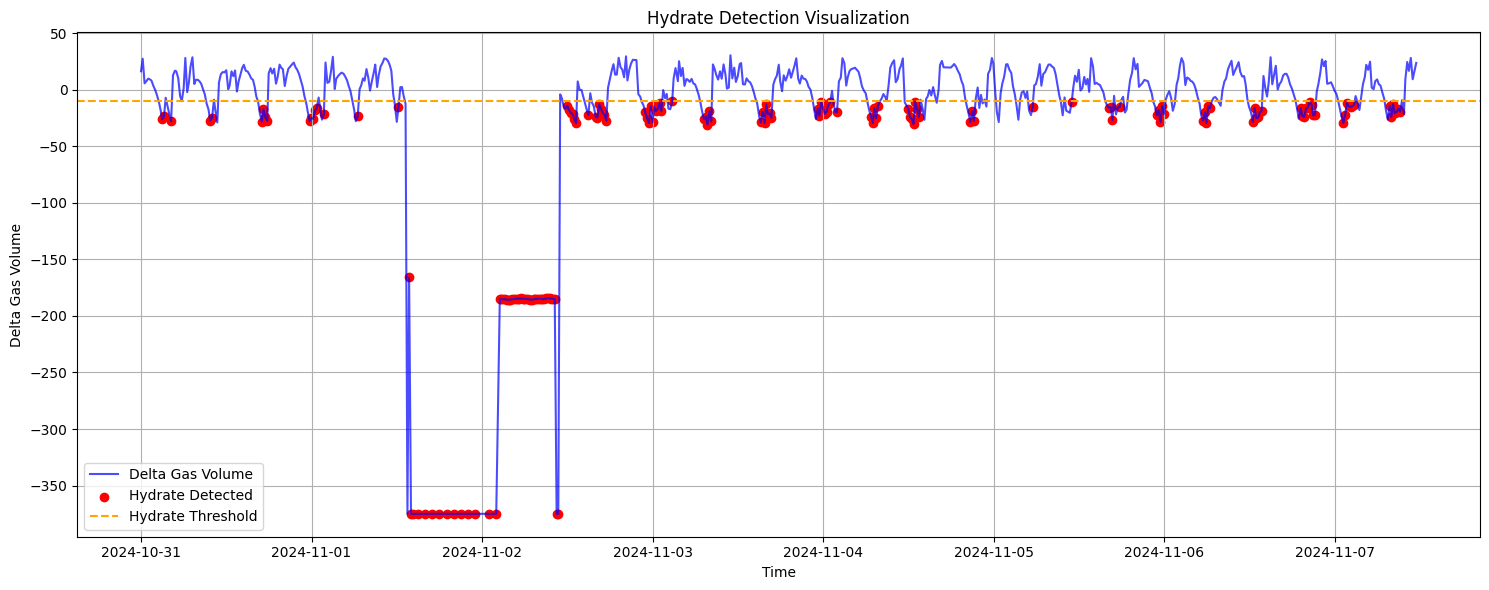

In [13]:
# Plot Delta Gas Volume with hydrate events highlighted
plt.figure(figsize=(15, 6))
plt.plot(data['Time'], data['Delta Gas Volume'], label='Delta Gas Volume', color='blue', alpha=0.7)
plt.scatter(data[data['Hydrate Detected'] == 1]['Time'],
            data[data['Hydrate Detected'] == 1]['Delta Gas Volume'],
            color='red', label='Hydrate Detected', marker='o')

plt.axhline(y=hydrate_threshold, color='orange', linestyle='--', label='Hydrate Threshold')
plt.title('Hydrate Detection Visualization')
plt.xlabel('Time')
plt.ylabel('Delta Gas Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the dataset for training
# Use relevant features and target
features = ['Delta Gas Volume', 'Valve Percent Change', 'Rolling Avg Delta Gas Volume']
target = 'Hydrate Detected'

# Drop NaN rows created by the diff() and rolling calculations
model_data = data.dropna()

X = model_data[features]
y = model_data[target]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the splits
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (540, 3)
Testing set shape: (136, 3)


In [15]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       104
           1       0.86      0.94      0.90        32

    accuracy                           0.95       136
   macro avg       0.92      0.94      0.93       136
weighted avg       0.95      0.95      0.95       136

Confusion Matrix:
[[99  5]
 [ 2 30]]


In [3]:
import pandas as pd

# Load the dataset
file_path = './data/Bold_744H-10_31-11_07.csv'  # Replace with the path to your CSV file
data = pd.read_csv(file_path)

# Display the first few rows
print("Dataset Loaded Successfully. Showing the first 5 rows:")
data.head()


Dataset Loaded Successfully. Showing the first 5 rows:


,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612
1,10/31/2024 12:14:00 am,402.52365,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,NaN,26.70198
3,10/31/2024 12:46:00 am,382.73955,NaN,NaN
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198


In [4]:
# Check for missing values
print("Missing Values Summary:")
print(data.isnull().sum())

# Handle missing values
# For now, we'll forward-fill missing values as an example. This can be refined later.
data.fillna(method='ffill', inplace=True)

# Verify missing values are handled
print("\nAfter Handling Missing Values:")
print(data.isnull().sum())

# Summary statistics
print("\nSummary Statistics:")
data.describe()


Missing Values Summary:
Time                                    0
Inj Gas Meter Volume Instantaneous      2
Inj Gas Meter Volume Setpoint         497
Inj Gas Valve Percent Open            363
dtype: int64

After Handling Missing Values:
Time                                  0
Inj Gas Meter Volume Instantaneous    0
Inj Gas Meter Volume Setpoint         0
Inj Gas Valve Percent Open            0
dtype: int64

Summary Statistics:


<ipython-input-4-227a05cc458a>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open
count,677.000000,677.0,677.000000
mean,356.988340,375.0,34.632537
std,70.040464,0.0,17.807582
min,0.000000,375.0,0.000000
25%,357.794850,375.0,27.478060
50%,374.232300,375.0,28.933010
75%,386.814450,375.0,32.676490
max,405.571950,375.0,100.000000


In [5]:
# Feature: Delta Gas Volume
data['Delta Gas Volume'] = data['Inj Gas Meter Volume Instantaneous'] - data['Inj Gas Meter Volume Setpoint']

# Feature: Rate of Change in Valve Percent Open
data['Valve Change Rate'] = data['Inj Gas Valve Percent Open'].diff()

# Rolling Averages and Standard Deviations (using a 3-sample window as an example)
data['Rolling Avg Delta Gas Volume'] = data['Delta Gas Volume'].rolling(window=3).mean()
data['Rolling Std Delta Gas Volume'] = data['Delta Gas Volume'].rolling(window=3).std()

# Display the first few rows with the new features
print("Feature Engineering Completed. Showing first 5 rows with new features:")
data.head()


Feature Engineering Completed. Showing first 5 rows with new features:


,Time,Inj Gas Meter Volume Instantaneous,Inj Gas Meter Volume Setpoint,Inj Gas Valve Percent Open,Delta Gas Volume,Valve Change Rate,Rolling Avg Delta Gas Volume,Rolling Std Delta Gas Volume
0,10/31/2024 12:00:00 am,391.43520,375.0,27.17612,16.43520,NaN,NaN,NaN
1,10/31/2024 12:14:00 am,402.52365,375.0,27.17612,27.52365,0.00000,NaN,NaN
2,10/31/2024 12:30:00 am,380.72775,375.0,26.70198,5.72775,-0.47414,16.56220,10.898505
3,10/31/2024 12:46:00 am,382.73955,375.0,26.70198,7.73955,0.00000,13.66365,12.045187
4,10/31/2024 1:00:00 am,384.86595,375.0,26.70198,9.86595,0.00000,7.77775,2.069364


In [6]:
# Rule-based Hydrate Detection: Label instances where Delta Gas Volume is significantly negative for a threshold duration
delta_threshold = -20  # Example threshold, can be tuned
data['Hydrate Detected'] = (data['Delta Gas Volume'] < delta_threshold).astype(int)

# Display the first few rows with the new label
print("Hydrate Detection Labels Added. Showing first 5 rows:")
data[['Time', 'Delta Gas Volume', 'Hydrate Detected']].head()


Hydrate Detection Labels Added. Showing first 5 rows:


,Time,Delta Gas Volume,Hydrate Detected
0,10/31/2024 12:00:00 am,16.43520,0
1,10/31/2024 12:14:00 am,27.52365,0
2,10/31/2024 12:30:00 am,5.72775,0
3,10/31/2024 12:46:00 am,7.73955,0
4,10/31/2024 1:00:00 am,9.86595,0


In [7]:
from sklearn.model_selection import train_test_split

# Select features and target variable
features = ['Delta Gas Volume', 'Valve Change Rate', 'Rolling Avg Delta Gas Volume', 'Rolling Std Delta Gas Volume']
target = 'Hydrate Detected'

# Drop rows with NaN values in rolling statistics (if any)
data_cleaned = data.dropna(subset=features)

# Split data into train and test sets (80% train, 20% test)
X = data_cleaned[features]
y = data_cleaned[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train and Test Sets Created Successfully.")
print(f"Training Set Size: {len(X_train)}")
print(f"Testing Set Size: {len(X_test)}")


Train and Test Sets Created Successfully.
Training Set Size: 540
Testing Set Size: 135


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Model Evaluation Metrics:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


Model Evaluation Metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        31

    accuracy                           1.00       135
   macro avg       1.00      1.00      1.00       135
weighted avg       1.00      1.00      1.00       135

Accuracy: 1.00


In [4]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


# Read the CSV file
df = pd.read_csv('./data/Bold_744H-10_31-11_07.csv')

# Display first few rows and basic information
print("First few rows of the dataset:")
print(df.head())
print("\nDataset Info:")
print(df.info())

First few rows of the dataset:
                     Time  Inj Gas Meter Volume Instantaneous  \
0  10/31/2024 12:00:00 am                           391.43520   
1  10/31/2024 12:14:00 am                           402.52365   
2  10/31/2024 12:30:00 am                           380.72775   
3  10/31/2024 12:46:00 am                           382.73955   
4   10/31/2024 1:00:00 am                           384.86595   

   Inj Gas Meter Volume Setpoint  Inj Gas Valve Percent Open  
0                          375.0                    27.17612  
1                            NaN                         NaN  
2                            NaN                    26.70198  
3                            NaN                         NaN  
4                          375.0                    26.70198  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 677 entries, 0 to 676
Data columns (total 4 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------     

In [5]:
# Data preprocessing
def preprocess_data(df):
    # Convert Time column to datetime
    df['Time'] = pd.to_datetime(df['Time'])

    # Forward fill the setpoint values since they should remain constant between updates
    df['Inj Gas Meter Volume Setpoint'] = df['Inj Gas Meter Volume Setpoint'].fillna(method='ffill')

    # Interpolate missing values in valve percent open (linear interpolation)
    df['Inj Gas Valve Percent Open'] = df['Inj Gas Valve Percent Open'].interpolate(method='linear')

    # Calculate key metrics
    df['Volume_Deviation'] = df['Inj Gas Meter Volume Setpoint'] - df['Inj Gas Meter Volume Instantaneous']

    # Calculate rate of change in volume (per hour)
    df['Volume_Change'] = df['Inj Gas Meter Volume Instantaneous'].diff() / \
                         (df['Time'].diff().dt.total_seconds() / 3600)

    # Calculate rolling mean of volume to smooth noise (2-hour window)
    df['Volume_Rolling_Mean'] = df['Inj Gas Meter Volume Instantaneous'].rolling(window=8).mean()

    return df

# Apply preprocessing
df_processed = preprocess_data(df.copy())

# Display the results
print("First few rows of processed data:")
print(df_processed.head())
print("\nDescriptive statistics of key metrics:")
print(df_processed.describe())

First few rows of processed data:
                 Time  Inj Gas Meter Volume Instantaneous  \
0 2024-10-31 00:00:00                           391.43520   
1 2024-10-31 00:14:00                           402.52365   
2 2024-10-31 00:30:00                           380.72775   
3 2024-10-31 00:46:00                           382.73955   
4 2024-10-31 01:00:00                           384.86595   

   Inj Gas Meter Volume Setpoint  Inj Gas Valve Percent Open  \
0                          375.0                    27.17612   
1                          375.0                    26.93905   
2                          375.0                    26.70198   
3                          375.0                    26.70198   
4                          375.0                    26.70198   

   Volume_Deviation  Volume_Change  Volume_Rolling_Mean  
0         -16.43520            NaN                  NaN  
1         -27.52365      47.521929                  NaN  
2          -5.72775     -81.734625      

In [7]:
def detect_hydrate_formation(df,
                           min_volume_threshold=50,     # Minimum volume to consider as normal operation
                           max_valve_threshold=90,      # Maximum valve opening to consider as potential hydrate
                           duration_threshold=2):       # Number of consecutive readings

    hydrate_events = []
    current_event = None
    consecutive_count = 0

    for i in range(len(df)):
        current_row = df.iloc[i]

        # Check conditions for hydrate formation
        # Looking for very low volume combined with high valve opening
        conditions_met = (
            current_row['Inj Gas Meter Volume Instantaneous'] < min_volume_threshold and
            current_row['Inj Gas Valve Percent Open'] > max_valve_threshold
        )

        if conditions_met:
            consecutive_count += 1
            if consecutive_count >= duration_threshold and current_event is None:
                # Look back a few readings to capture the start of the decline
                start_idx = max(0, i-4)
                current_event = {
                    'start_time': df.iloc[start_idx]['Time'],
                    'initial_volume': df.iloc[start_idx]['Inj Gas Meter Volume Instantaneous'],
                    'initial_valve': df.iloc[start_idx]['Inj Gas Valve Percent Open']
                }
        else:
            if current_event is not None:
                current_event['end_time'] = current_row['Time']
                current_event['final_volume'] = current_row['Inj Gas Meter Volume Instantaneous']
                current_event['final_valve'] = current_row['Inj Gas Valve Percent Open']
                current_event['duration'] = (current_event['end_time'] - current_event['start_time'])
                hydrate_events.append(current_event)
                current_event = None
            consecutive_count = 0

    # Handle case where event is ongoing at end of data
    if current_event is not None:
        current_event['end_time'] = df.iloc[-1]['Time']
        current_event['final_volume'] = df.iloc[-1]['Inj Gas Meter Volume Instantaneous']
        current_event['final_valve'] = df.iloc[-1]['Inj Gas Valve Percent Open']
        current_event['duration'] = (current_event['end_time'] - current_event['start_time'])
        hydrate_events.append(current_event)

    return hydrate_events

# Detect hydrate events with new thresholds
hydrate_events = detect_hydrate_formation(df_processed)

# Print detected events with more detailed information
print(f"Detected {len(hydrate_events)} potential hydrate formation events:\n")
for i, event in enumerate(hydrate_events, 1):
    print(f"Event {i}:")
    print(f"Start Time: {event['start_time']}")
    print(f"End Time: {event['end_time']}")
    print(f"Duration: {event['duration']}")
    print(f"Initial Volume: {event['initial_volume']:.2f}")
    print(f"Final Volume: {event['final_volume']:.2f}")
    print(f"Initial Valve Opening: {event['initial_valve']:.2f}%")
    print(f"Final Valve Opening: {event['final_valve']:.2f}%")
    print("---")

Detected 1 potential hydrate formation events:

Event 1:
Start Time: 2024-11-01 13:44:00
End Time: 2024-11-02 02:30:00
Duration: 0 days 12:46:00
Initial Volume: 209.00
Final Volume: 189.80
Initial Valve Opening: 62.10%
Final Valve Opening: 100.00%
---


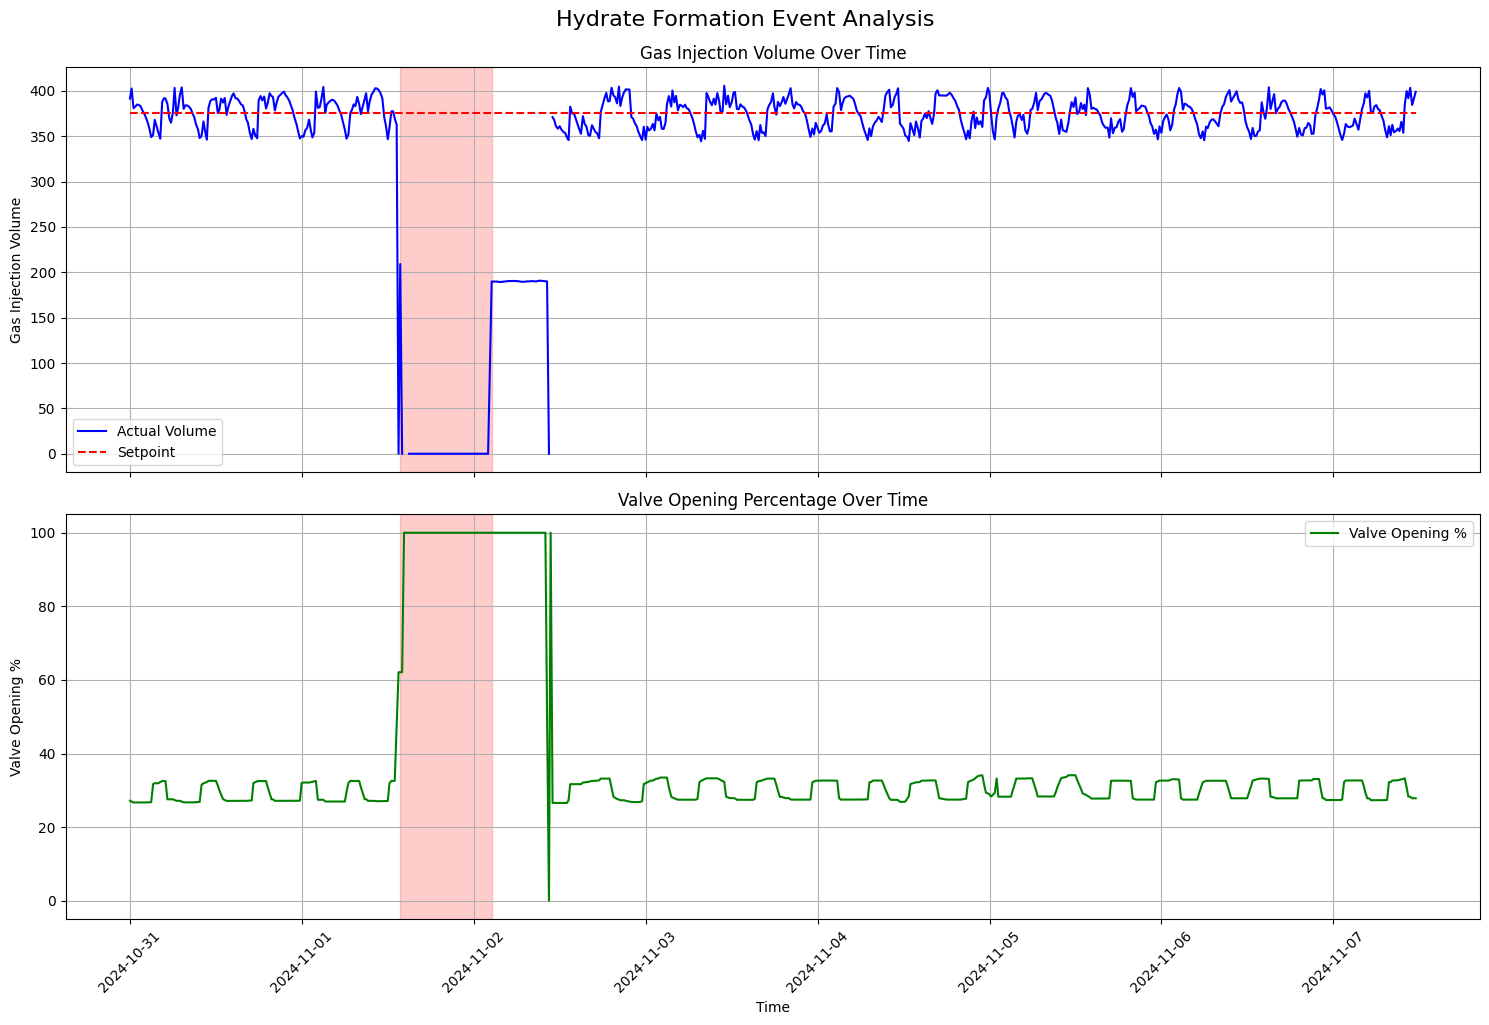


Hydrate Event Statistics:
Duration: 0 days 12:46:00
Volume drop: -19.20
Valve opening increase: 37.90%
Average volume before event: 375.47
Average volume during event: 28.49
Average valve opening before event: 29.17%
Average valve opening during event: 94.95%


In [8]:
# Create a figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot gas injection volume
ax1.plot(df_processed['Time'], df_processed['Inj Gas Meter Volume Instantaneous'],
         label='Actual Volume', color='blue')
ax1.plot(df_processed['Time'], df_processed['Inj Gas Meter Volume Setpoint'],
         label='Setpoint', color='red', linestyle='--')

# Highlight the hydrate event period
event = hydrate_events[0]
ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)
ax1.set_ylabel('Gas Injection Volume')
ax1.set_title('Gas Injection Volume Over Time')
ax1.legend()
ax1.grid(True)

# Plot valve opening percentage
ax2.plot(df_processed['Time'], df_processed['Inj Gas Valve Percent Open'],
         label='Valve Opening %', color='green')
ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)
ax2.set_ylabel('Valve Opening %')
ax2.set_xlabel('Time')
ax2.set_title('Valve Opening Percentage Over Time')
ax2.legend()
ax2.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Hydrate Formation Event Analysis', y=1.02, fontsize=16)

# Display the plot
plt.show()

# Print event statistics
print("\nHydrate Event Statistics:")
print(f"Duration: {event['duration']}")
print(f"Volume drop: {event['final_volume'] - event['initial_volume']:.2f}")
print(f"Valve opening increase: {event['final_valve'] - event['initial_valve']:.2f}%")
print(f"Average volume before event: {df_processed[df_processed['Time'] < event['start_time']]['Inj Gas Meter Volume Instantaneous'].mean():.2f}")
print(f"Average volume during event: {df_processed[(df_processed['Time'] >= event['start_time']) & (df_processed['Time'] <= event['end_time'])]['Inj Gas Meter Volume Instantaneous'].mean():.2f}")
print(f"Average valve opening before event: {df_processed[df_processed['Time'] < event['start_time']]['Inj Gas Valve Percent Open'].mean():.2f}%")
print(f"Average valve opening during event: {df_processed[(df_processed['Time'] >= event['start_time']) & (df_processed['Time'] <= event['end_time'])]['Inj Gas Valve Percent Open'].mean():.2f}%")

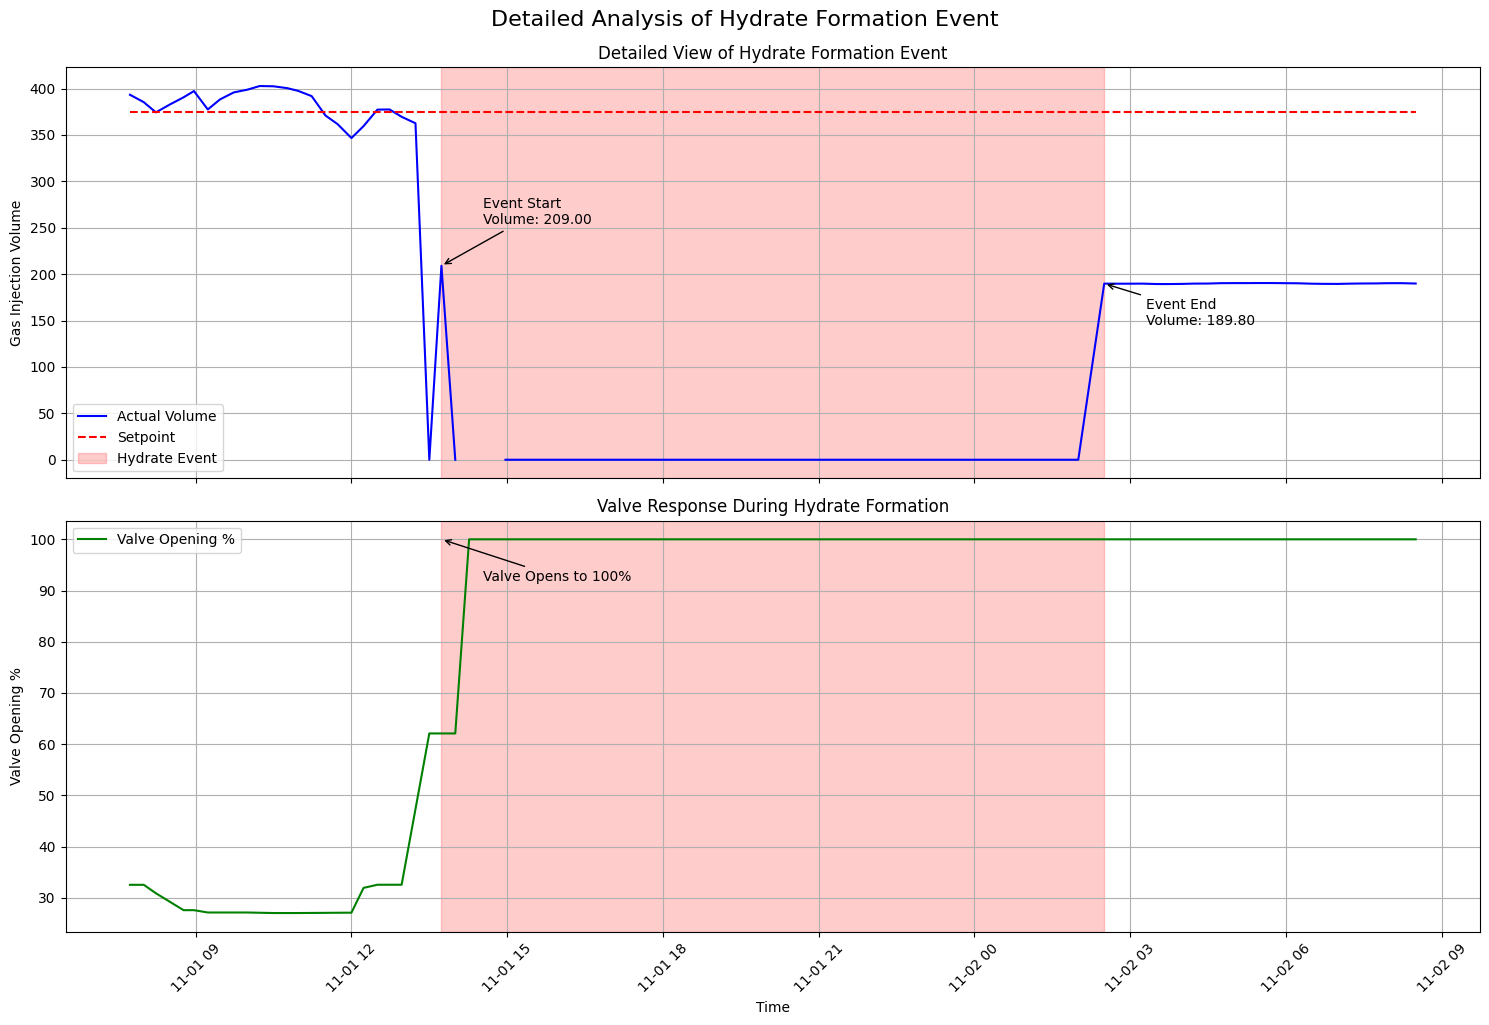


Detailed Event Analysis:
------------------------
Event Start: 2024-11-01 13:44
Event End: 2024-11-02 02:30
Total Duration: 0 days 12:46:00

Volume Analysis:
Initial Volume: 209.00
Minimum Volume During Event: 0.00
Volume Drop: 209.00

Valve Analysis:
Initial Valve Opening: 62.10%
Maximum Valve Opening: 100.00%
Valve Opening Increase: 37.90%


In [9]:
# Create a figure with two subplots sharing x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Calculate the time window for zoomed view
event_start = event['start_time'] - pd.Timedelta(hours=6)  # 6 hours before event
event_end = event['end_time'] + pd.Timedelta(hours=6)     # 6 hours after event

# Filter data for the time window
mask = (df_processed['Time'] >= event_start) & (df_processed['Time'] <= event_end)
df_event = df_processed[mask]

# Plot gas injection volume
ax1.plot(df_event['Time'], df_event['Inj Gas Meter Volume Instantaneous'],
         label='Actual Volume', color='blue')
ax1.plot(df_event['Time'], df_event['Inj Gas Meter Volume Setpoint'],
         label='Setpoint', color='red', linestyle='--')

# Highlight the hydrate event period
ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2,
            label='Hydrate Event')

# Add annotations
ax1.annotate('Event Start\nVolume: {:.2f}'.format(event['initial_volume']),
            xy=(event['start_time'], event['initial_volume']),
            xytext=(30, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax1.annotate('Event End\nVolume: {:.2f}'.format(event['final_volume']),
            xy=(event['end_time'], event['final_volume']),
            xytext=(30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax1.set_ylabel('Gas Injection Volume')
ax1.set_title('Detailed View of Hydrate Formation Event')
ax1.legend()
ax1.grid(True)

# Plot valve opening percentage
ax2.plot(df_event['Time'], df_event['Inj Gas Valve Percent Open'],
         label='Valve Opening %', color='green')
ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

# Add annotations for valve
ax2.annotate('Valve Opens to 100%',
            xy=(event['start_time'], event['final_valve']),
            xytext=(30, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle='->'))

ax2.set_ylabel('Valve Opening %')
ax2.set_xlabel('Time')
ax2.set_title('Valve Response During Hydrate Formation')
ax2.legend()
ax2.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()

# Add a title for the entire figure
fig.suptitle('Detailed Analysis of Hydrate Formation Event', y=1.02, fontsize=16)

# Display the plot
plt.show()

# Print detailed analysis
print("\nDetailed Event Analysis:")
print("------------------------")
print(f"Event Start: {event['start_time'].strftime('%Y-%m-%d %H:%M')}")
print(f"Event End: {event['end_time'].strftime('%Y-%m-%d %H:%M')}")
print(f"Total Duration: {event['duration']}")
print("\nVolume Analysis:")
print(f"Initial Volume: {event['initial_volume']:.2f}")
print(f"Minimum Volume During Event: {df_event['Inj Gas Meter Volume Instantaneous'].min():.2f}")
print(f"Volume Drop: {event['initial_volume'] - df_event['Inj Gas Meter Volume Instantaneous'].min():.2f}")
print("\nValve Analysis:")
print(f"Initial Valve Opening: {event['initial_valve']:.2f}%")
print(f"Maximum Valve Opening: {df_event['Inj Gas Valve Percent Open'].max():.2f}%")
print(f"Valve Opening Increase: {df_event['Inj Gas Valve Percent Open'].max() - event['initial_valve']:.2f}%")

In [10]:
def monitor_hydrate_formation(current_volume, current_valve, setpoint,
                            volume_warning_threshold=0.6,  # 60% of setpoint
                            valve_warning_threshold=50,    # 50% valve opening
                            critical_volume_threshold=0.3, # 30% of setpoint
                            critical_valve_threshold=80):  # 80% valve opening

    # Calculate volume as percentage of setpoint
    volume_percentage = (current_volume / setpoint) * 100

    # Initialize status dictionary
    status = {
        'status': 'Normal',
        'alert_level': 0,  # 0: Normal, 1: Warning, 2: Critical
        'messages': []
    }

    # Check for warning conditions
    if volume_percentage < volume_warning_threshold * 100:
        status['messages'].append(f"WARNING: Volume at {volume_percentage:.1f}% of setpoint")
        status['alert_level'] = 1

    if current_valve > valve_warning_threshold:
        status['messages'].append(f"WARNING: Valve opening at {current_valve:.1f}%")
        status['alert_level'] = 1

    # Check for critical conditions
    if volume_percentage < critical_volume_threshold * 100:
        status['messages'].append(f"CRITICAL: Volume dropped to {volume_percentage:.1f}% of setpoint")
        status['alert_level'] = 2

    if current_valve > critical_valve_threshold:
        status['messages'].append(f"CRITICAL: Valve opening critical at {current_valve:.1f}%")
        status['alert_level'] = 2

    # Set overall status
    if status['alert_level'] == 0:
        status['status'] = 'Normal Operation'
    elif status['alert_level'] == 1:
        status['status'] = 'Warning - Potential Hydrate Formation'
    else:
        status['status'] = 'Critical - Likely Hydrate Formation'

    return status

# Test the monitoring function on our event data
print("Example of monitoring alerts before, during, and after the hydrate event:\n")

# Before event (1 hour before)
before_idx = df_processed[df_processed['Time'] < event['start_time']].index[-4]
before_data = df_processed.loc[before_idx]
print("1 hour before event:")
status = monitor_hydrate_formation(
    before_data['Inj Gas Meter Volume Instantaneous'],
    before_data['Inj Gas Valve Percent Open'],
    before_data['Inj Gas Meter Volume Setpoint']
)
print(f"Status: {status['status']}")
print("Messages:", *status['messages'], sep='\n- ' if status['messages'] else 'None')
print()

# During event start
during_idx = df_processed[df_processed['Time'] == event['start_time']].index[0]
during_data = df_processed.loc[during_idx]
print("At event start:")
status = monitor_hydrate_formation(
    during_data['Inj Gas Meter Volume Instantaneous'],
    during_data['Inj Gas Valve Percent Open'],
    during_data['Inj Gas Meter Volume Setpoint']
)
print(f"Status: {status['status']}")
print("Messages:", *status['messages'], sep='\n- ' if status['messages'] else 'None')
print()

# During event (middle)
mid_event_time = event['start_time'] + (event['end_time'] - event['start_time'])/2
mid_idx = df_processed[df_processed['Time'] >= mid_event_time].index[0]
mid_data = df_processed.loc[mid_idx]
print("During event:")
status = monitor_hydrate_formation(
    mid_data['Inj Gas Meter Volume Instantaneous'],
    mid_data['Inj Gas Valve Percent Open'],
    mid_data['Inj Gas Meter Volume Setpoint']
)
print(f"Status: {status['status']}")
print("Messages:", *status['messages'], sep='\n- ' if status['messages'] else 'None')

Example of monitoring alerts before, during, and after the hydrate event:

1 hour before event:
Status: Normal Operation
Messages:

At event start:
Status: Warning - Potential Hydrate Formation
Messages:
- WARNING: Volume at 55.7% of setpoint
- WARNING: Valve opening at 62.1%

During event:
Status: Critical - Likely Hydrate Formation
Messages:
- WARNING: Volume at 0.0% of setpoint
- WARNING: Valve opening at 100.0%
- CRITICAL: Volume dropped to 0.0% of setpoint
- CRITICAL: Valve opening critical at 100.0%


Analyzing all wells for hydrate events...


Processing ./data/Bold_744H-10_31-11_07.csv...

Results for Bold_744H-10_31-11_07:
Found 1 hydrate event(s):

Event 1:
Start Time: 2024-11-01 13:44:00
End Time: 2024-11-02 02:30:00
Duration: 0 days 12:46:00
Initial Volume: 209.00
Final Volume: 189.80
Initial Valve Opening: 62.10%
Final Valve Opening: 100.00%

Processing ./data/Courageous_729H-09_25-09_28.csv...

Results for Courageous_729H-09_25-09_28:
Found 1 hydrate event(s):

Event 1:
Start Time: 2024-09-27 20:46:00
End Time: 2024-09-27 21:00:00
Duration: 0 days 00:14:00
Initial Volume: 365.99
Final Volume: 374.85
Initial Valve Opening: 100.00%
Final Valve Opening: 100.00%

Processing ./data/Fearless_709H-10_31-11_07.csv...

Results for Fearless_709H-10_31-11_07:
Found 1 hydrate event(s):

Event 1:
Start Time: 2024-11-01 12:58:00
End Time: 2024-11-01 14:44:00
Duration: 0 days 01:46:00
Initial Volume: 509.78
Final Volume: 607.07
Initial Valve Opening: 55.64%
Final Valve Opening: 47.79%

Pro

<Figure size 1500x800 with 0 Axes>

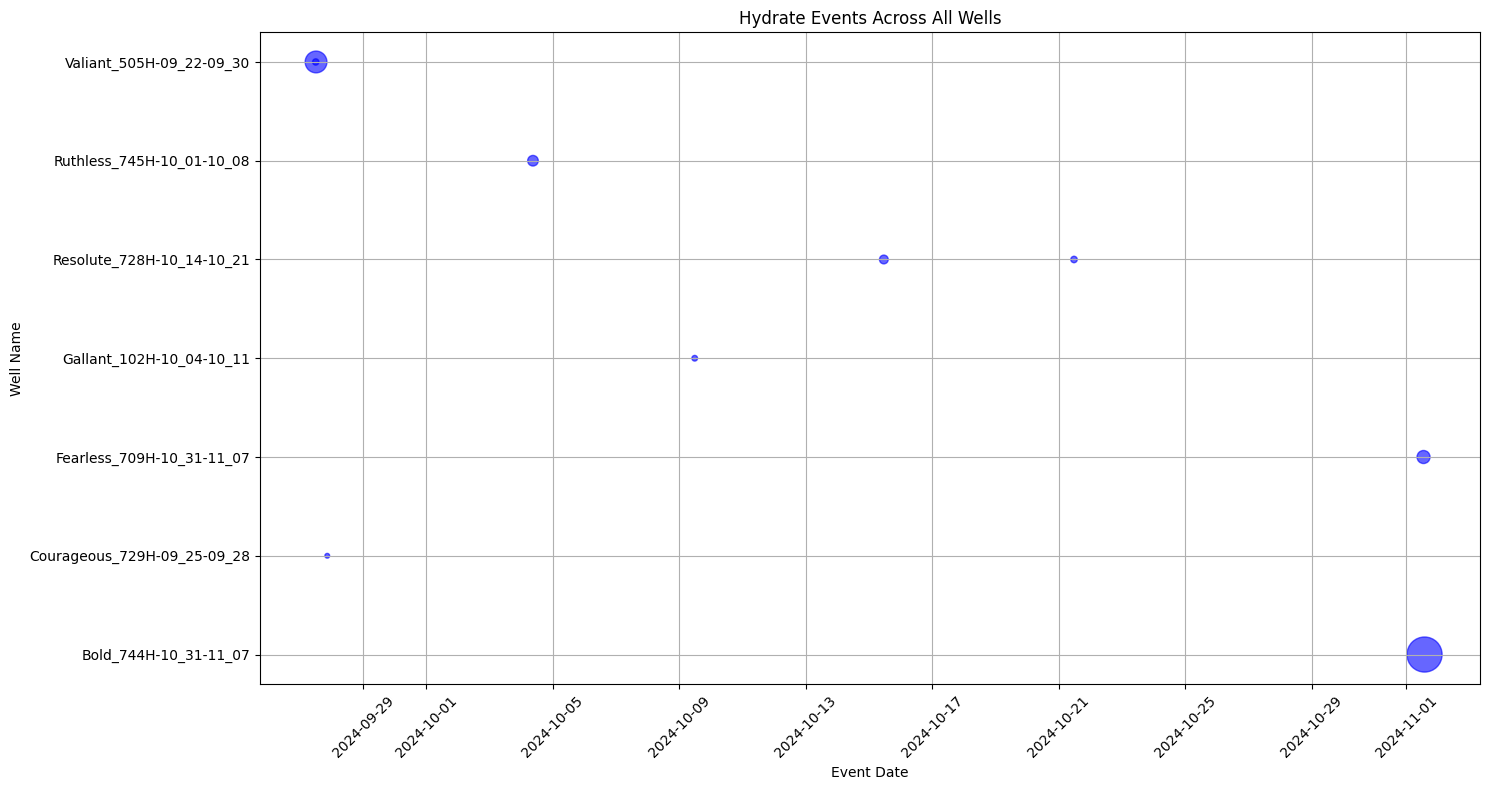


Summary Statistics:
--------------------------------------------------
Total wells analyzed: 8
Wells with hydrate events: 7
Total hydrate events detected: 9
Average event duration: 2.54 hours
Longest event: 12.77 hours
Shortest event: 0.23 hours


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

# List of CSV files you mentioned
csv_files = [
    './data/Bold_744H-10_31-11_07.csv',
    './data/Courageous_729H-09_25-09_28.csv',
    './data/Fearless_709H-10_31-11_07.csv',
    './data/Gallant_102H-10_04-10_11.csv',
    './data/Noble_4H-10_24-10_29.csv',
    './data/Resolute_728H-10_14-10_21.csv',
    './data/Ruthless_745H-10_01-10_08.csv',
    './data/Steadfast_505H-10_30-11_07.csv',
    './data/Valiant_505H-09_22-09_30.csv'
]

def analyze_well_data(file_path):
    """Analyze a single well's data file for hydrate events"""
    try:
        print(f"\nProcessing {file_path}...")

        # Read and process the data
        df = pd.read_csv(file_path)
        df_processed = preprocess_data(df)

        # Detect hydrate events
        events = detect_hydrate_formation(df_processed)

        # Get well name from file name
        well_name = os.path.basename(file_path).split('.')[0]

        return {
            'well_name': well_name,
            'events': events,
            'data': df_processed
        }
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

# Analyze all wells
well_analyses = {}
print("Analyzing all wells for hydrate events...\n")

for file_path in csv_files:
    if os.path.exists(file_path):
        analysis = analyze_well_data(file_path)
        if analysis:
            well_analyses[analysis['well_name']] = analysis

            print(f"\nResults for {analysis['well_name']}:")
            if analysis['events']:
                print(f"Found {len(analysis['events'])} hydrate event(s):")
                for i, event in enumerate(analysis['events'], 1):
                    print(f"\nEvent {i}:")
                    print(f"Start Time: {event['start_time']}")
                    print(f"End Time: {event['end_time']}")
                    print(f"Duration: {event['duration']}")
                    print(f"Initial Volume: {event['initial_volume']:.2f}")
                    print(f"Final Volume: {event['final_volume']:.2f}")
                    print(f"Initial Valve Opening: {event['initial_valve']:.2f}%")
                    print(f"Final Valve Opening: {event['final_valve']:.2f}%")
            else:
                print("No hydrate events detected")
    else:
        print(f"File not found: {file_path}")

# Create a summary visualization if we have events
if well_analyses:
    plt.figure(figsize=(15, 8))

    # Prepare data for visualization
    wells_with_events = []
    event_durations = []
    event_dates = []

    for well_name, analysis in well_analyses.items():
        for event in analysis['events']:
            wells_with_events.append(well_name)
            event_durations.append(event['duration'].total_seconds() / 3600)  # Convert to hours
            event_dates.append(event['start_time'])

    if event_dates:  # Only create plot if we have events
        plt.figure(figsize=(15, 8))

        # Create scatter plot with bigger bubbles and better colors
        plt.scatter(event_dates, wells_with_events,
                   s=[d*50 for d in event_durations],  # Increased bubble size
                   alpha=0.6,
                   c='blue')

        plt.xlabel('Event Date')
        plt.ylabel('Well Name')
        plt.title('Hydrate Events Across All Wells')

        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    print(f"Total wells analyzed: {len(well_analyses)}")
    print(f"Wells with hydrate events: {len(set(wells_with_events))}")
    print(f"Total hydrate events detected: {len(event_dates)}")
    if event_durations:
        print(f"Average event duration: {sum(event_durations)/len(event_durations):.2f} hours")
        print(f"Longest event: {max(event_durations):.2f} hours")
        print(f"Shortest event: {min(event_durations):.2f} hours")
else:
    print("\nNo wells could be analyzed. Please check file paths and data format.")


Processing ./data/Bold_744H-10_31-11_07.csv...


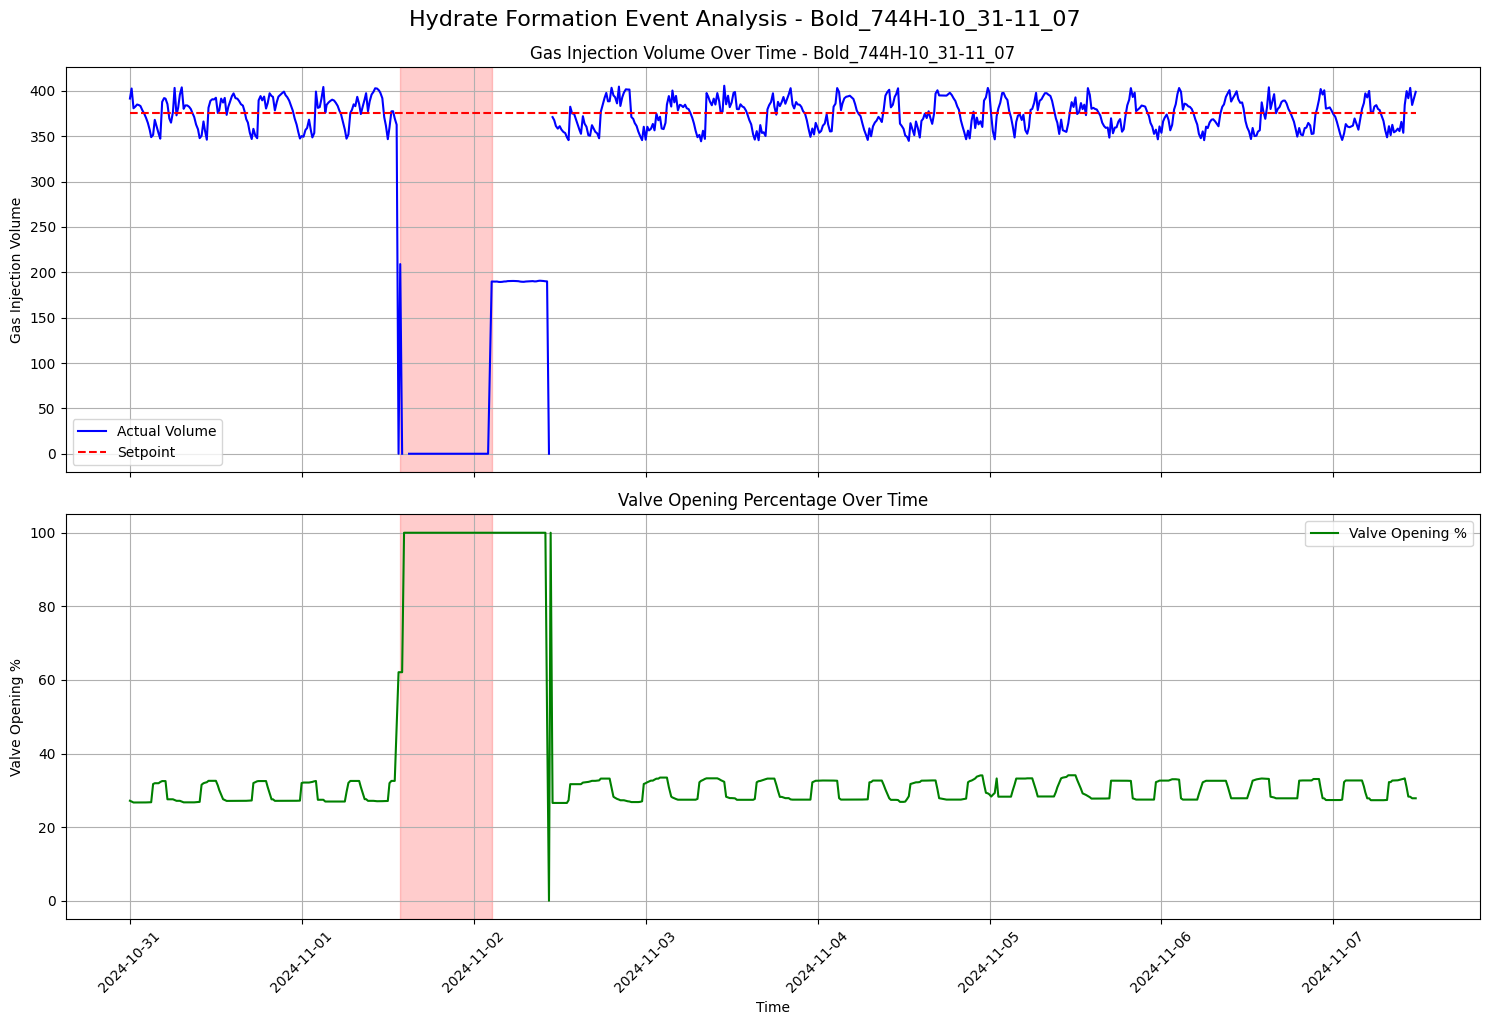


Event Statistics for Bold_744H-10_31-11_07:

Event 1:
Start Time: 2024-11-01 13:44:00
End Time: 2024-11-02 02:30:00
Duration: 0 days 12:46:00
Initial Volume: 209.00
Final Volume: 189.80
Initial Valve Opening: 62.10%
Final Valve Opening: 100.00%
--------------------------------------------------

Processing ./data/Courageous_729H-09_25-09_28.csv...


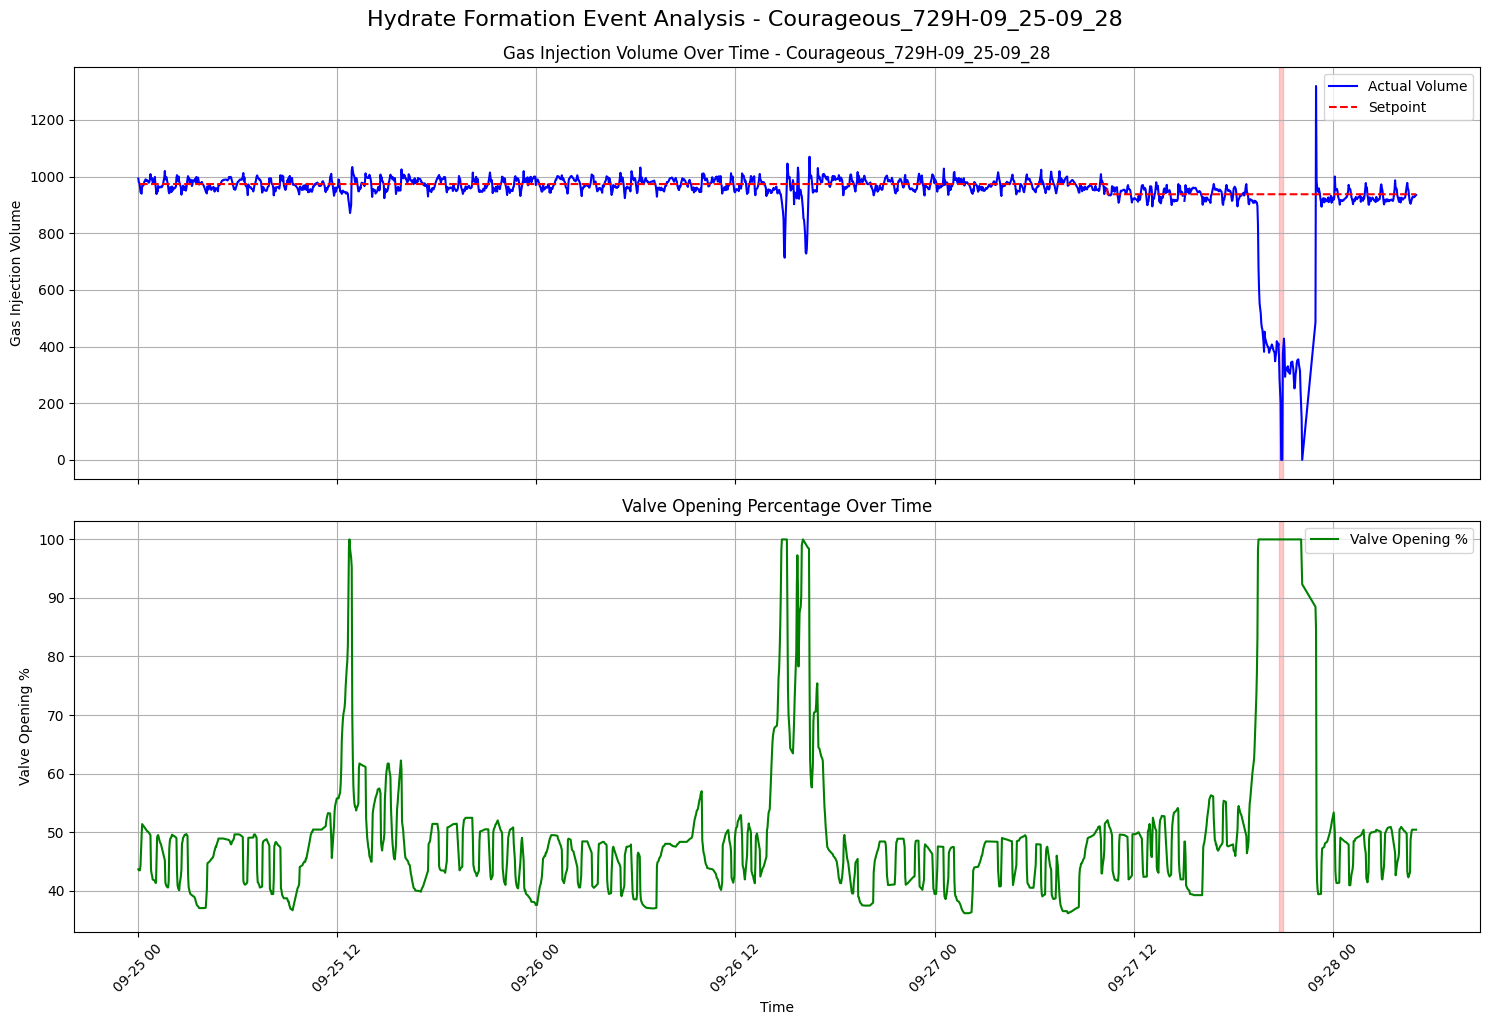


Event Statistics for Courageous_729H-09_25-09_28:

Event 1:
Start Time: 2024-09-27 20:46:00
End Time: 2024-09-27 21:00:00
Duration: 0 days 00:14:00
Initial Volume: 365.99
Final Volume: 374.85
Initial Valve Opening: 100.00%
Final Valve Opening: 100.00%
--------------------------------------------------

Processing ./data/Fearless_709H-10_31-11_07.csv...


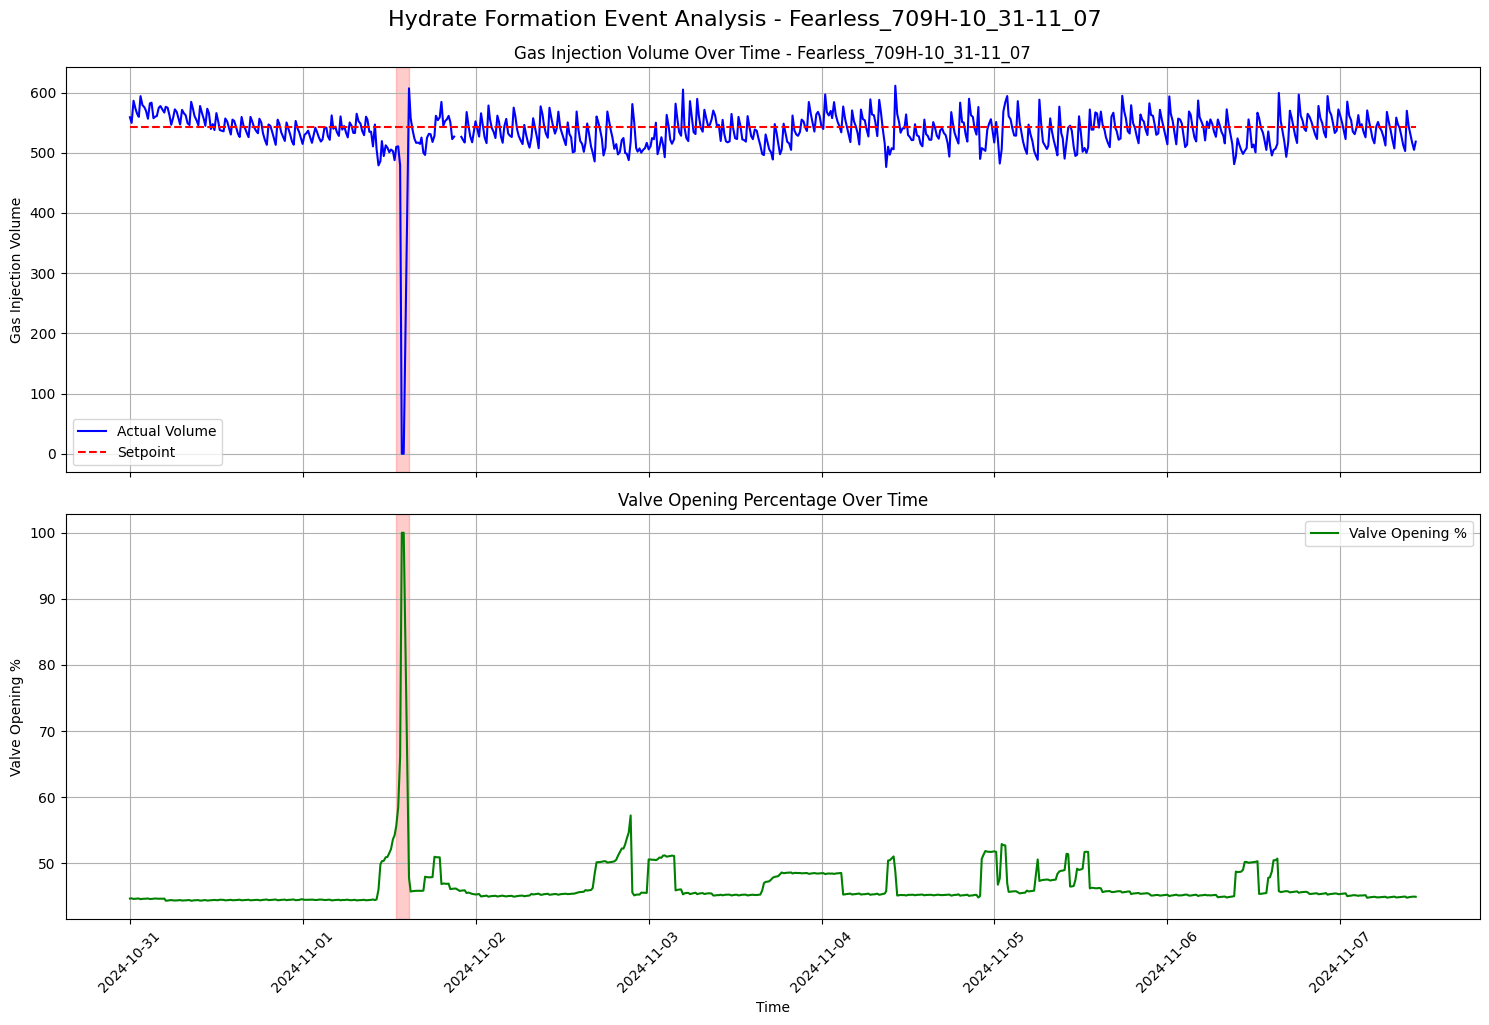


Event Statistics for Fearless_709H-10_31-11_07:

Event 1:
Start Time: 2024-11-01 12:58:00
End Time: 2024-11-01 14:44:00
Duration: 0 days 01:46:00
Initial Volume: 509.78
Final Volume: 607.07
Initial Valve Opening: 55.64%
Final Valve Opening: 47.79%
--------------------------------------------------

Processing ./data/Gallant_102H-10_04-10_11.csv...


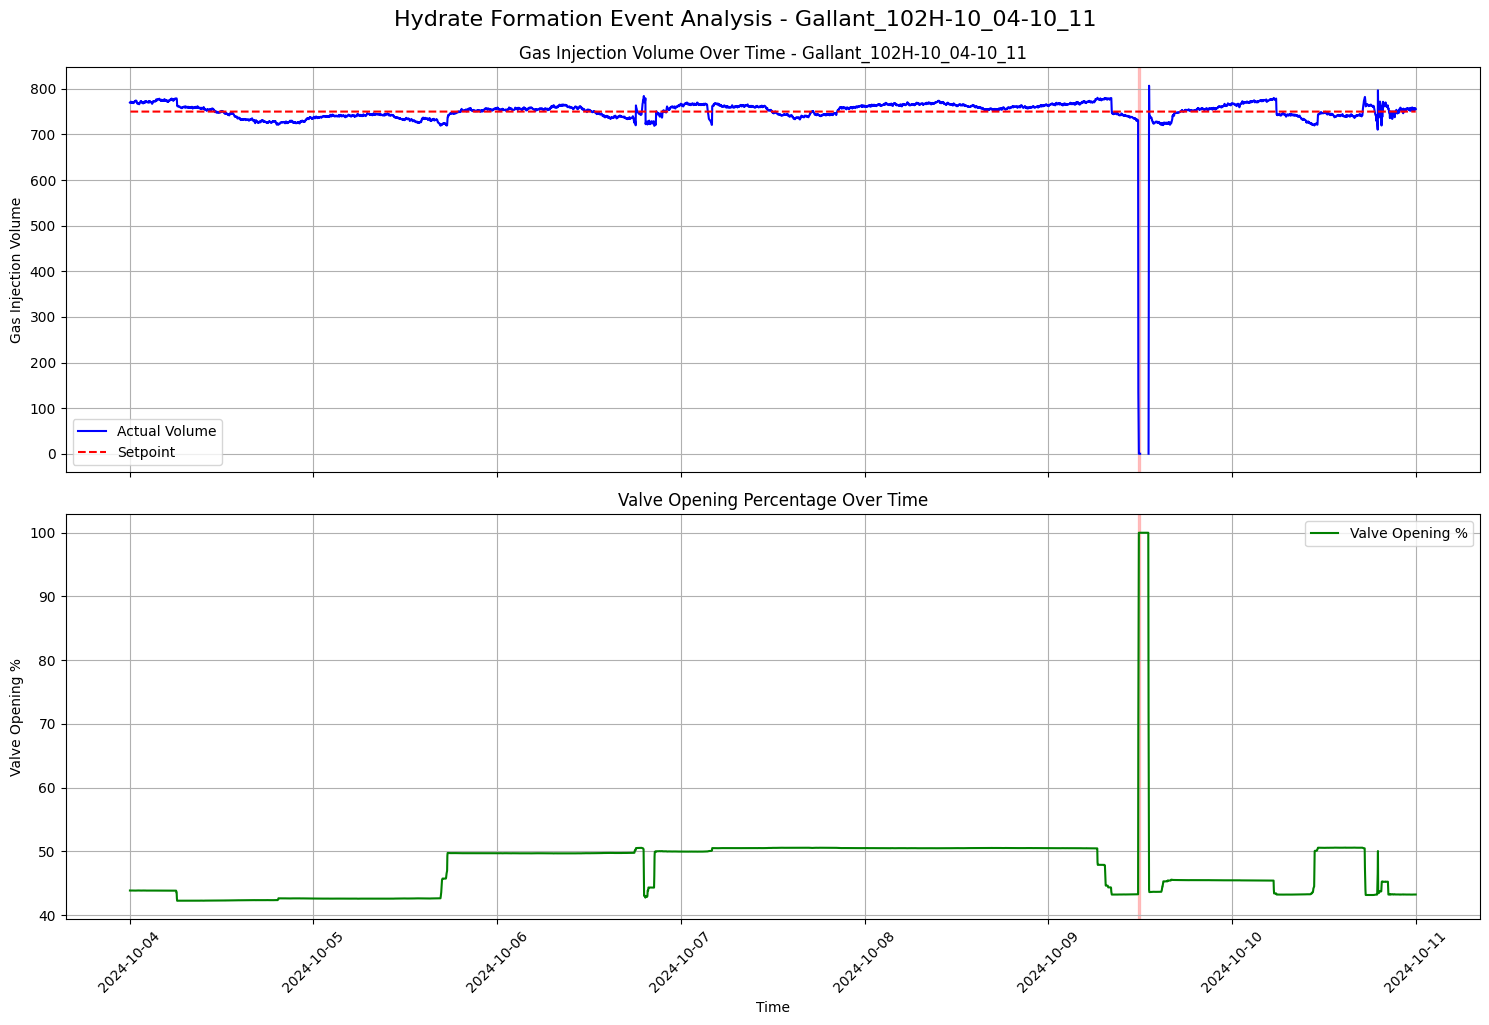


Event Statistics for Gallant_102H-10_04-10_11:

Event 1:
Start Time: 2024-10-09 11:42:00
End Time: 2024-10-09 12:02:00
Duration: 0 days 00:20:00
Initial Volume: 729.75
Final Volume: nan
Initial Valve Opening: 43.27%
Final Valve Opening: 100.00%
--------------------------------------------------

Processing ./data/Noble_4H-10_24-10_29.csv...


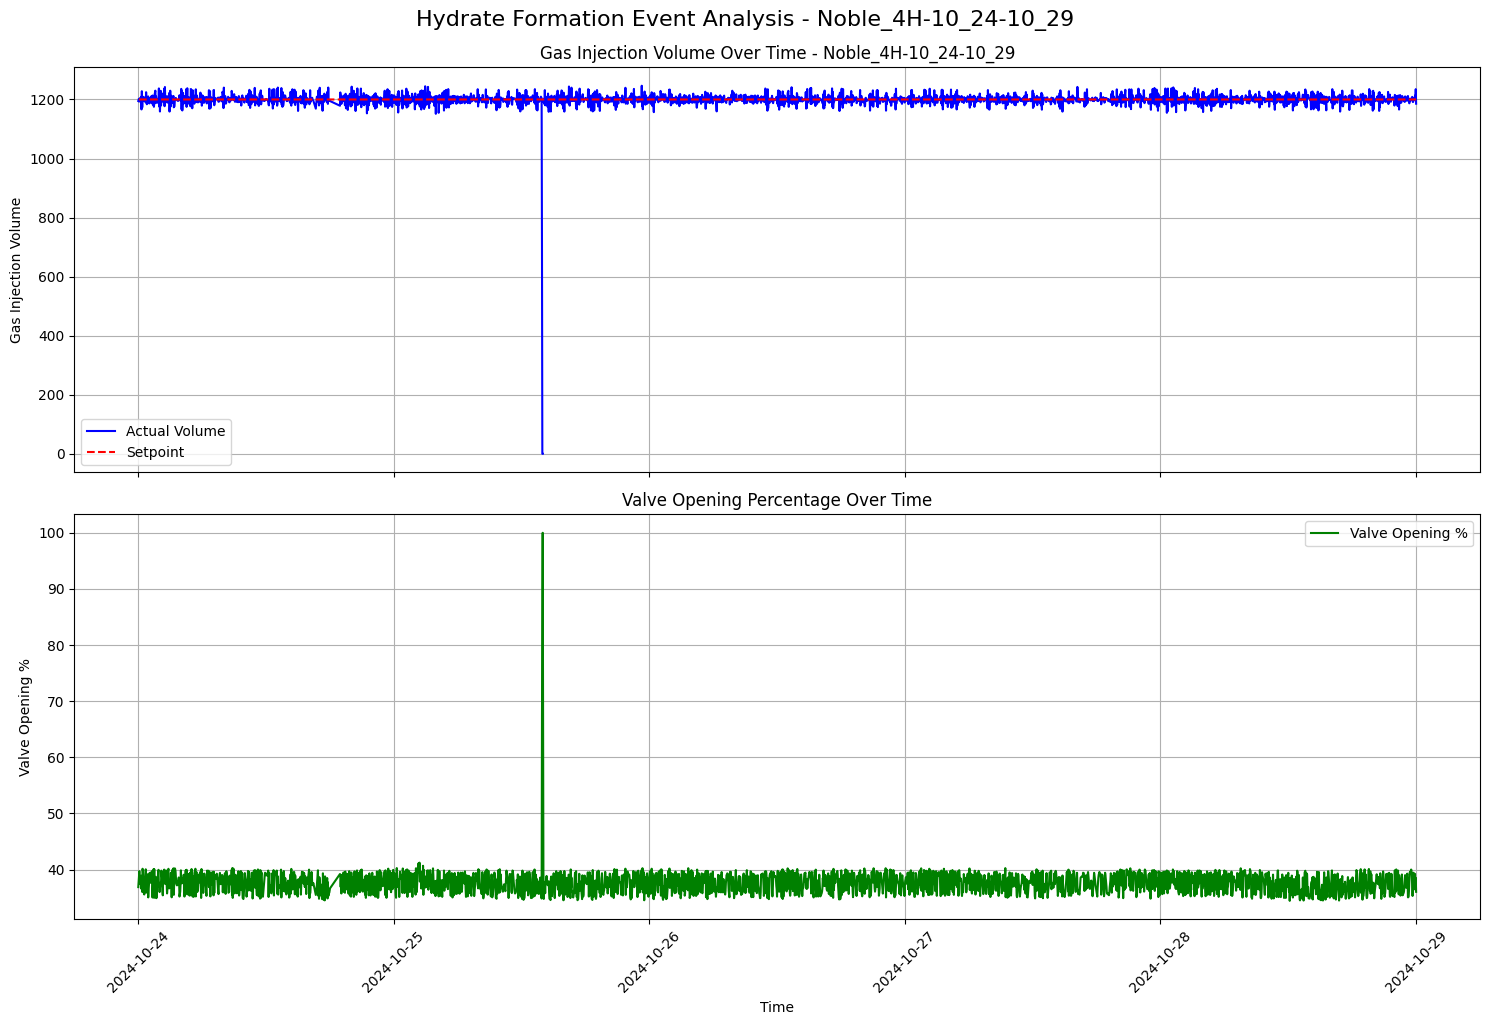


No hydrate events detected for Noble_4H-10_24-10_29
--------------------------------------------------

Processing ./data/Resolute_728H-10_14-10_21.csv...


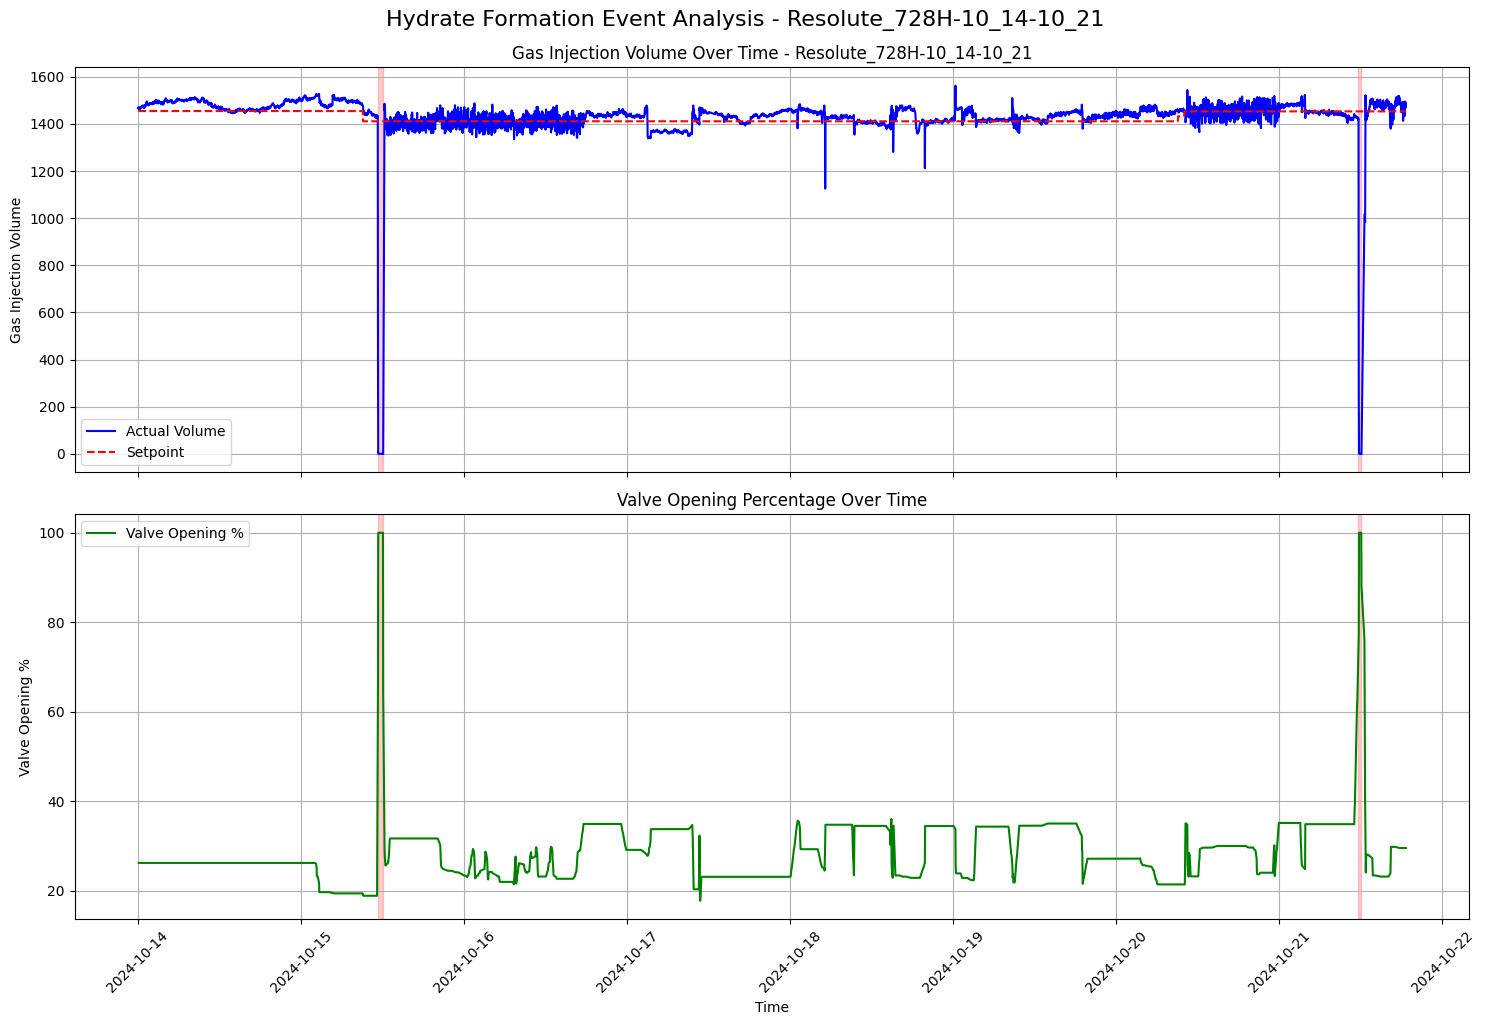


Event Statistics for Resolute_728H-10_14-10_21:

Event 1:
Start Time: 2024-10-15 11:16:00
End Time: 2024-10-15 12:04:00
Duration: 0 days 00:48:00
Initial Volume: 1432.88
Final Volume: nan
Initial Valve Opening: 42.54%
Final Valve Opening: 100.00%

Event 2:
Start Time: 2024-10-21 11:38:00
End Time: 2024-10-21 12:04:00
Duration: 0 days 00:26:00
Initial Volume: 1425.00
Final Volume: nan
Initial Valve Opening: 72.55%
Final Valve Opening: 100.00%
--------------------------------------------------

Processing ./data/Ruthless_745H-10_01-10_08.csv...


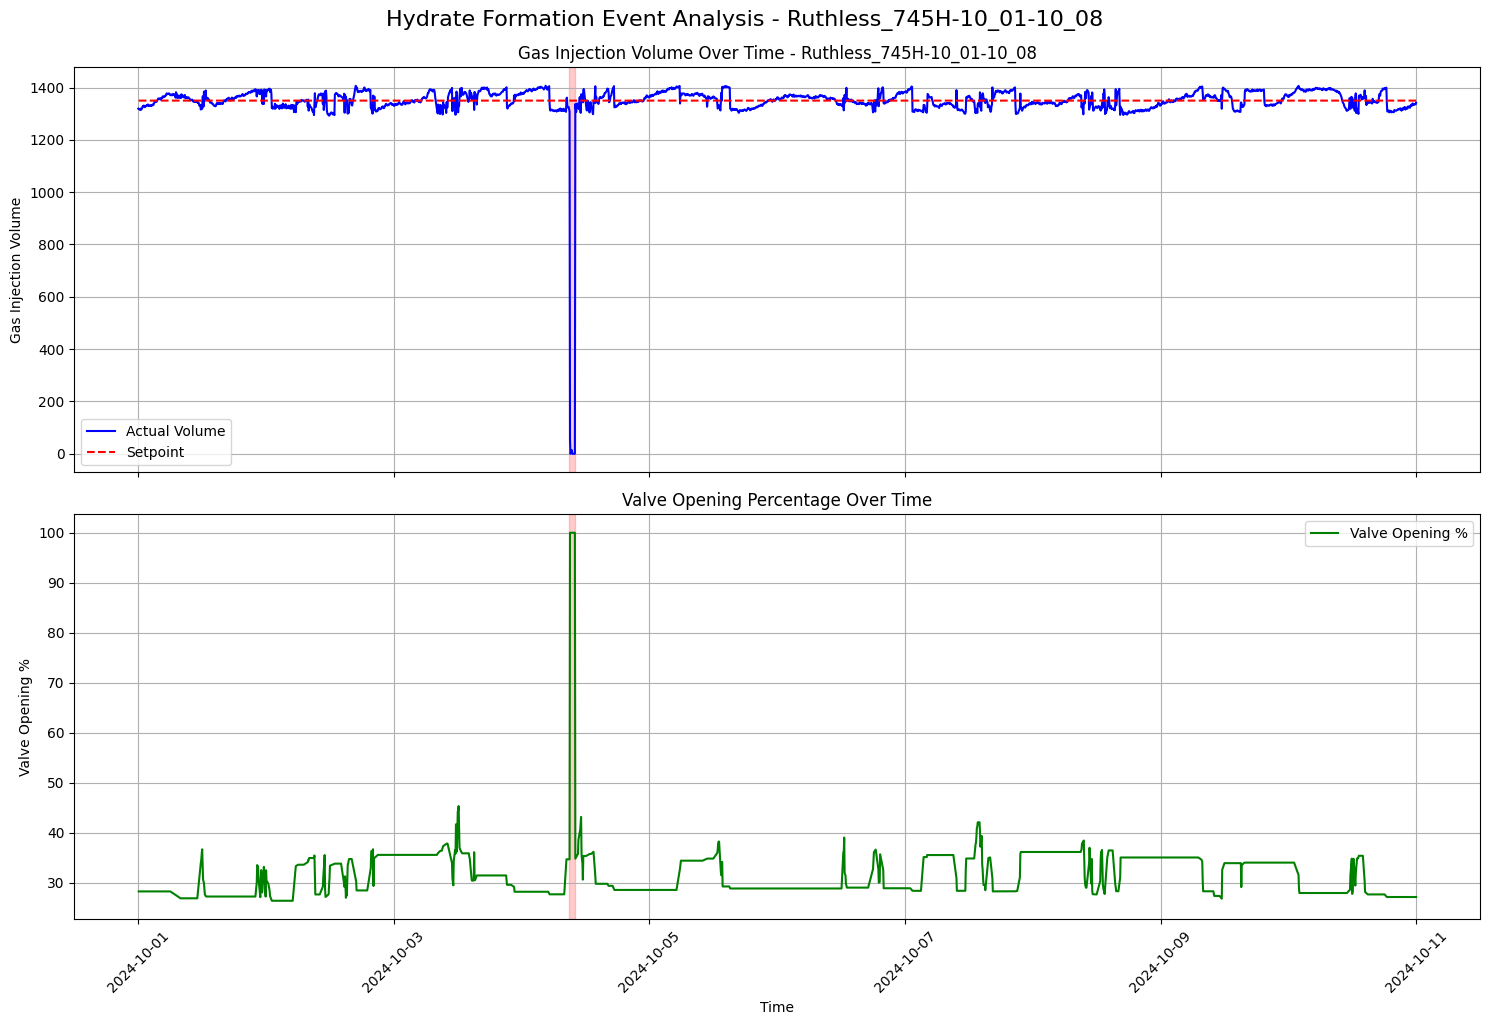


Event Statistics for Ruthless_745H-10_01-10_08:

Event 1:
Start Time: 2024-10-04 08:55:00
End Time: 2024-10-04 10:05:00
Duration: 0 days 01:10:00
Initial Volume: 1315.76
Final Volume: 1336.74
Initial Valve Opening: 34.73%
Final Valve Opening: 34.86%
--------------------------------------------------

Processing ./data/Steadfast_505H-10_30-11_07.csv...
Error processing ./data/Steadfast_505H-10_30-11_07.csv: time data "10/30/2024 12:00:00 pm" doesn't match format "%m/%d/%Y %H:%M:%S am", at position 93. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Processing ./data/Valiant_505H-09_22-09_30.csv...


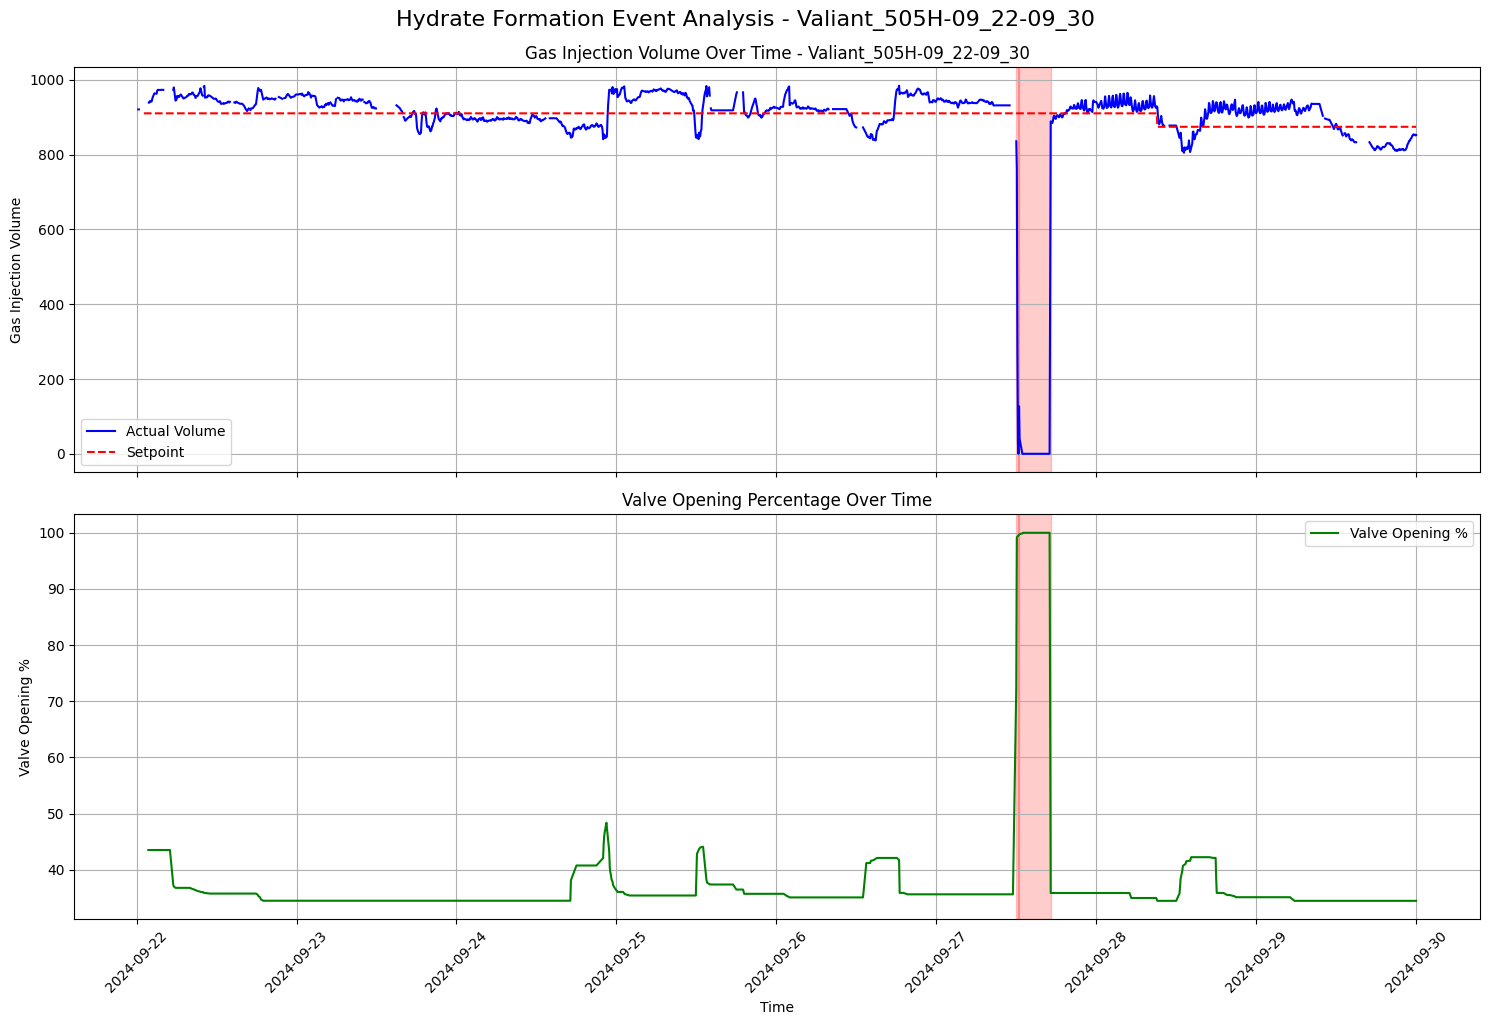


Event Statistics for Valiant_505H-09_22-09_30:

Event 1:
Start Time: 2024-09-27 12:00:00
End Time: 2024-09-27 12:25:00
Duration: 0 days 00:25:00
Initial Volume: 835.66
Final Volume: 127.13
Initial Valve Opening: 72.60%
Final Valve Opening: 99.65%

Event 2:
Start Time: 2024-09-27 12:15:00
End Time: 2024-09-27 17:10:00
Duration: 0 days 04:55:00
Initial Volume: 30.43
Final Volume: 889.04
Initial Valve Opening: 99.42%
Final Valve Opening: 35.87%
--------------------------------------------------

Overall Summary:
--------------------------------------------------
Total files processed: 9


In [12]:
def plot_well_data(df_processed, events, well_name):
    """Create detailed visualization for a single well"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    # Plot gas injection volume
    ax1.plot(df_processed['Time'], df_processed['Inj Gas Meter Volume Instantaneous'],
             label='Actual Volume', color='blue')
    ax1.plot(df_processed['Time'], df_processed['Inj Gas Meter Volume Setpoint'],
             label='Setpoint', color='red', linestyle='--')

    # Highlight hydrate events
    for event in events:
        ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

    ax1.set_ylabel('Gas Injection Volume')
    ax1.set_title(f'Gas Injection Volume Over Time - {well_name}')
    ax1.legend()
    ax1.grid(True)

    # Plot valve opening percentage
    ax2.plot(df_processed['Time'], df_processed['Inj Gas Valve Percent Open'],
             label='Valve Opening %', color='green')

    # Highlight hydrate events
    for event in events:
        ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

    ax2.set_ylabel('Valve Opening %')
    ax2.set_xlabel('Time')
    ax2.set_title('Valve Opening Percentage Over Time')
    ax2.legend()
    ax2.grid(True)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add a title for the entire figure
    fig.suptitle(f'Hydrate Formation Event Analysis - {well_name}', y=1.02, fontsize=16)

    # Display the plot
    plt.show()

    # Print event statistics for this well
    if events:
        print(f"\nEvent Statistics for {well_name}:")
        for i, event in enumerate(events, 1):
            print(f"\nEvent {i}:")
            print(f"Start Time: {event['start_time']}")
            print(f"End Time: {event['end_time']}")
            print(f"Duration: {event['duration']}")
            print(f"Initial Volume: {event['initial_volume']:.2f}")
            print(f"Final Volume: {event['final_volume']:.2f}")
            print(f"Initial Valve Opening: {event['initial_valve']:.2f}%")
            print(f"Final Valve Opening: {event['final_valve']:.2f}%")
    else:
        print(f"\nNo hydrate events detected for {well_name}")
    print("-" * 50)

# Process and plot each CSV file
for file_path in csv_files:
    if os.path.exists(file_path):
        try:
            print(f"\nProcessing {file_path}...")

            # Read and process the data
            df = pd.read_csv(file_path)
            df_processed = preprocess_data(df)

            # Detect hydrate events
            events = detect_hydrate_formation(df_processed)

            # Get well name from file name
            well_name = os.path.basename(file_path).split('.')[0]

            # Create visualization
            plot_well_data(df_processed, events, well_name)

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    else:
        print(f"File not found: {file_path}")

# Print overall summary
print("\nOverall Summary:")
print("-" * 50)
print(f"Total files processed: {len([f for f in csv_files if os.path.exists(f)])}")


Processing ./data/Bold_744H-10_31-11_07.csv...


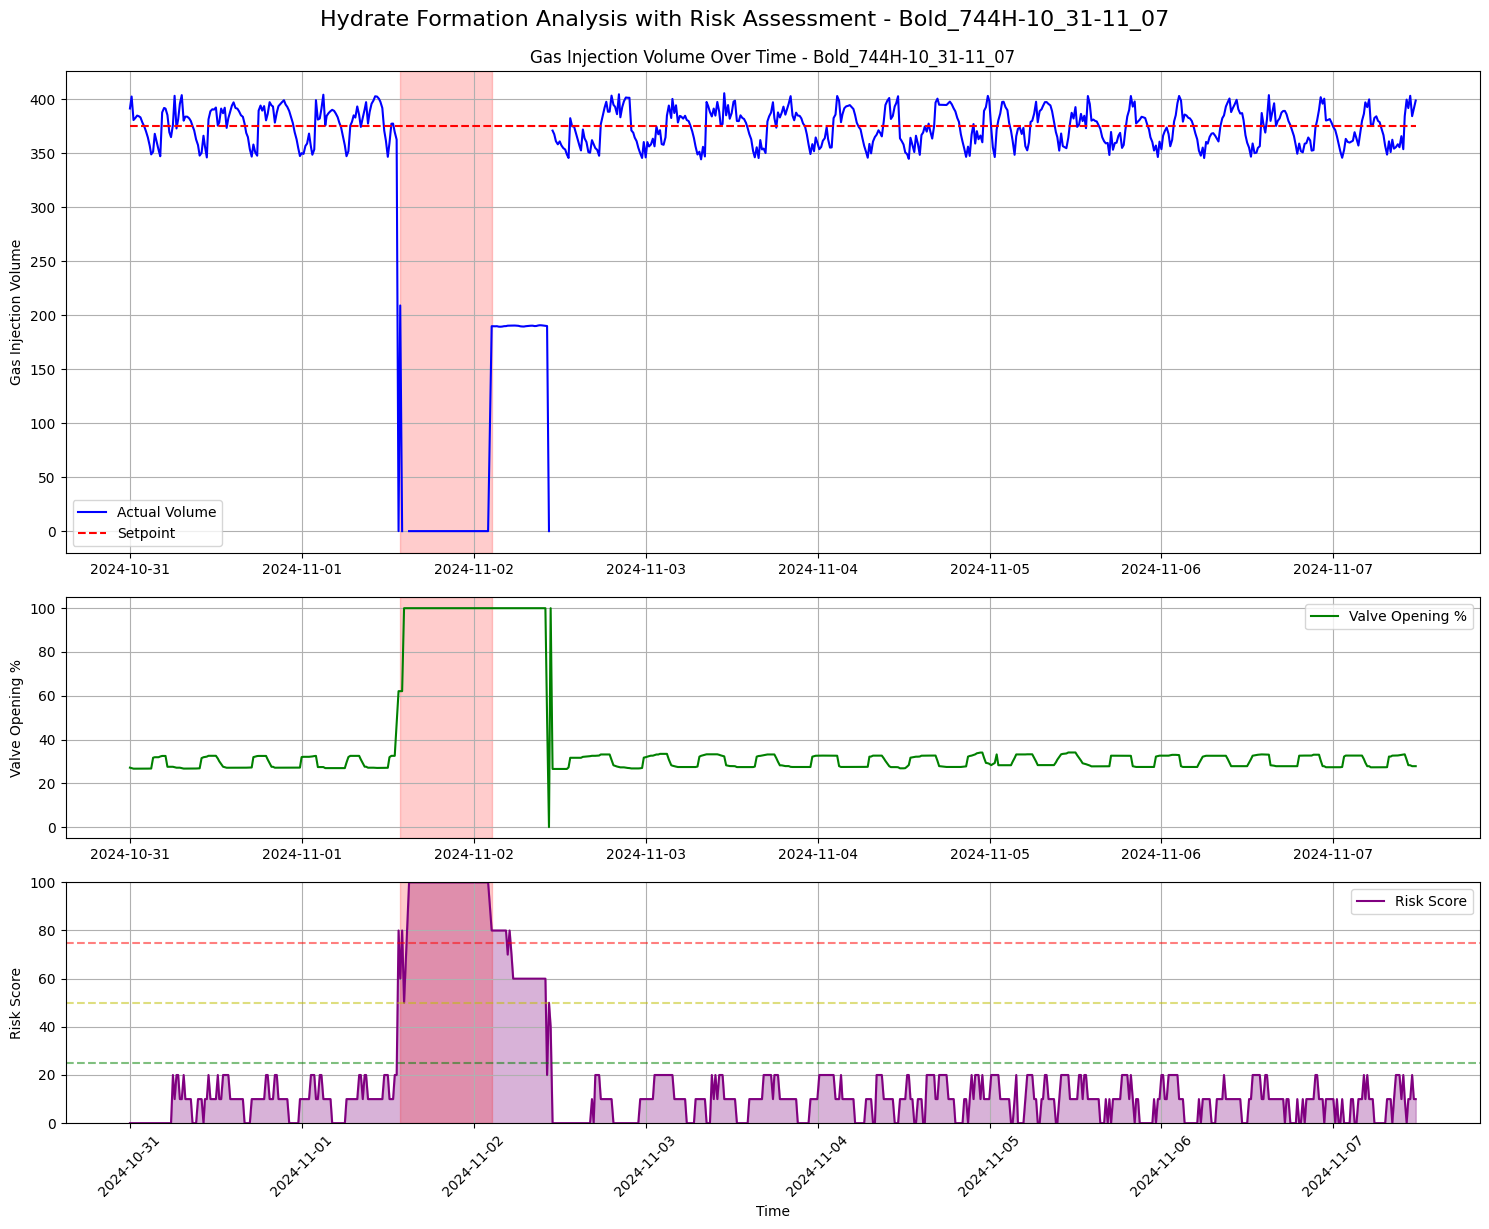


Risk Analysis for Bold_744H-10_31-11_07:
--------------------------------------------------
Average Risk Score: 13.62
Maximum Risk Score: 100.00
Time spent in high risk (>75): 3.4%
Time spent in medium risk (50-75): 3.2%
Time spent in low risk (<50): 93.4%

Processing ./data/Courageous_729H-09_25-09_28.csv...


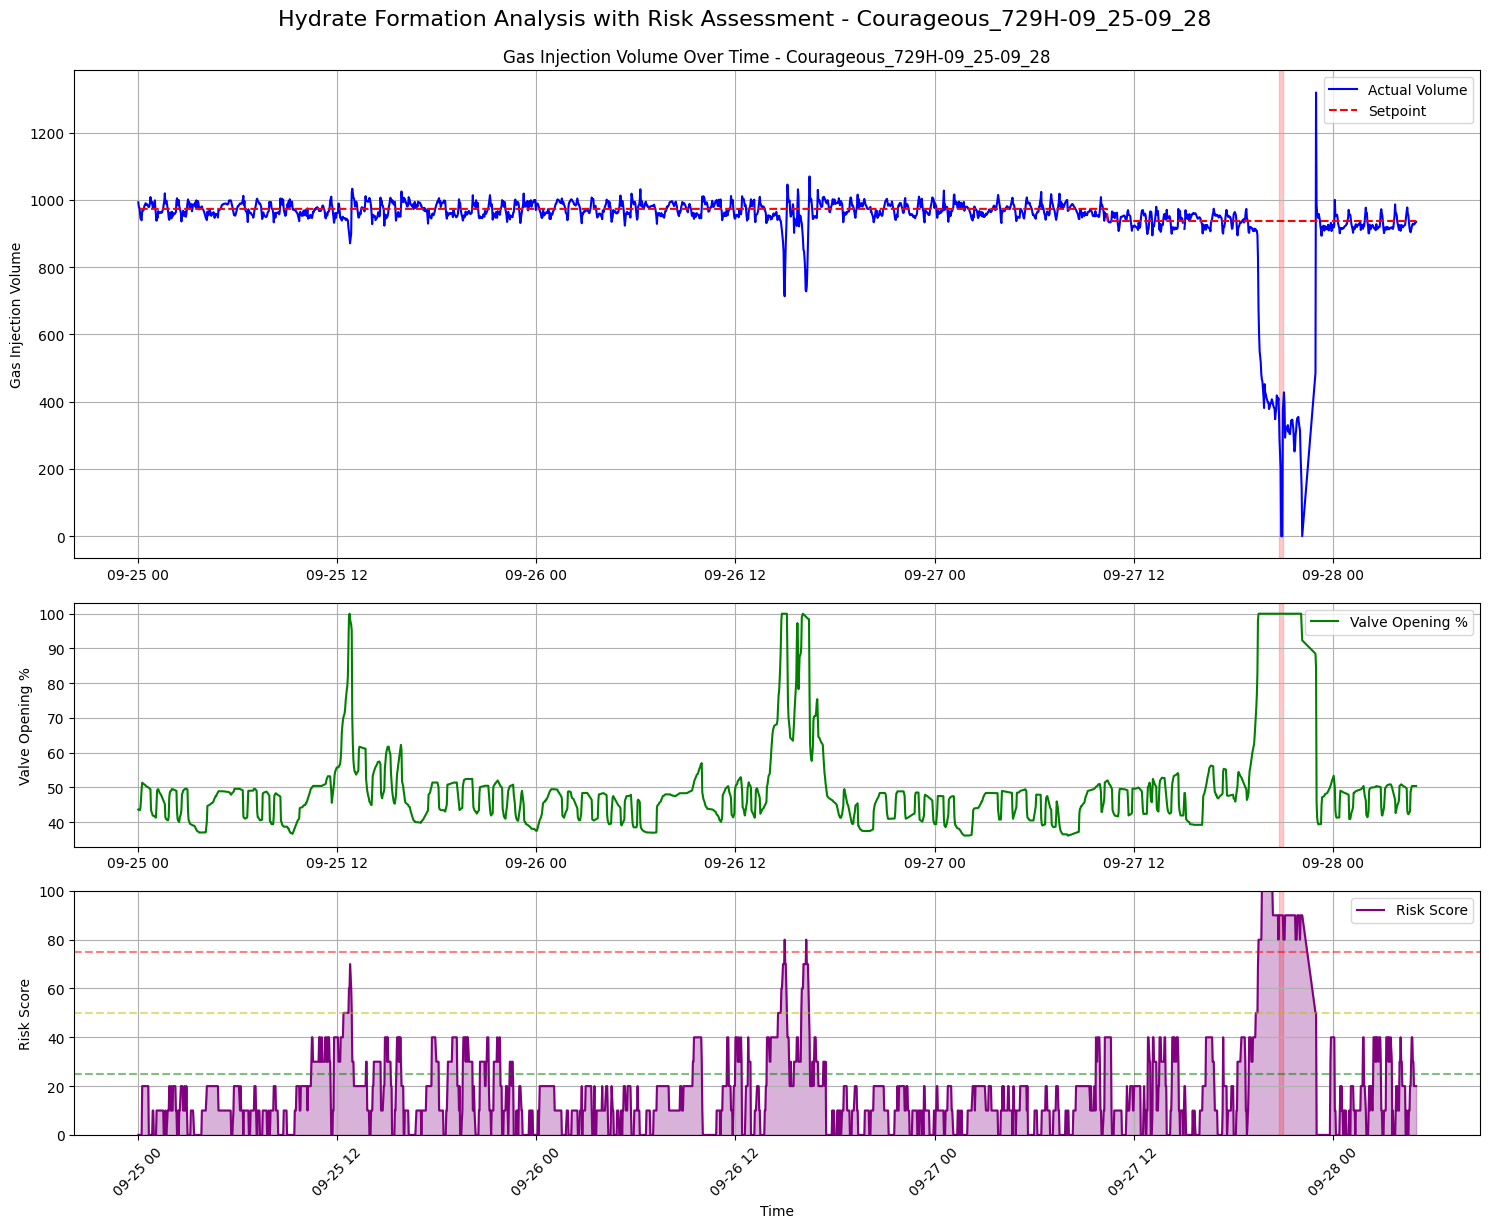


Risk Analysis for Courageous_729H-09_25-09_28:
--------------------------------------------------
Average Risk Score: 18.16
Maximum Risk Score: 100.00
Time spent in high risk (>75): 3.5%
Time spent in medium risk (50-75): 1.1%
Time spent in low risk (<50): 95.4%

Processing ./data/Fearless_709H-10_31-11_07.csv...


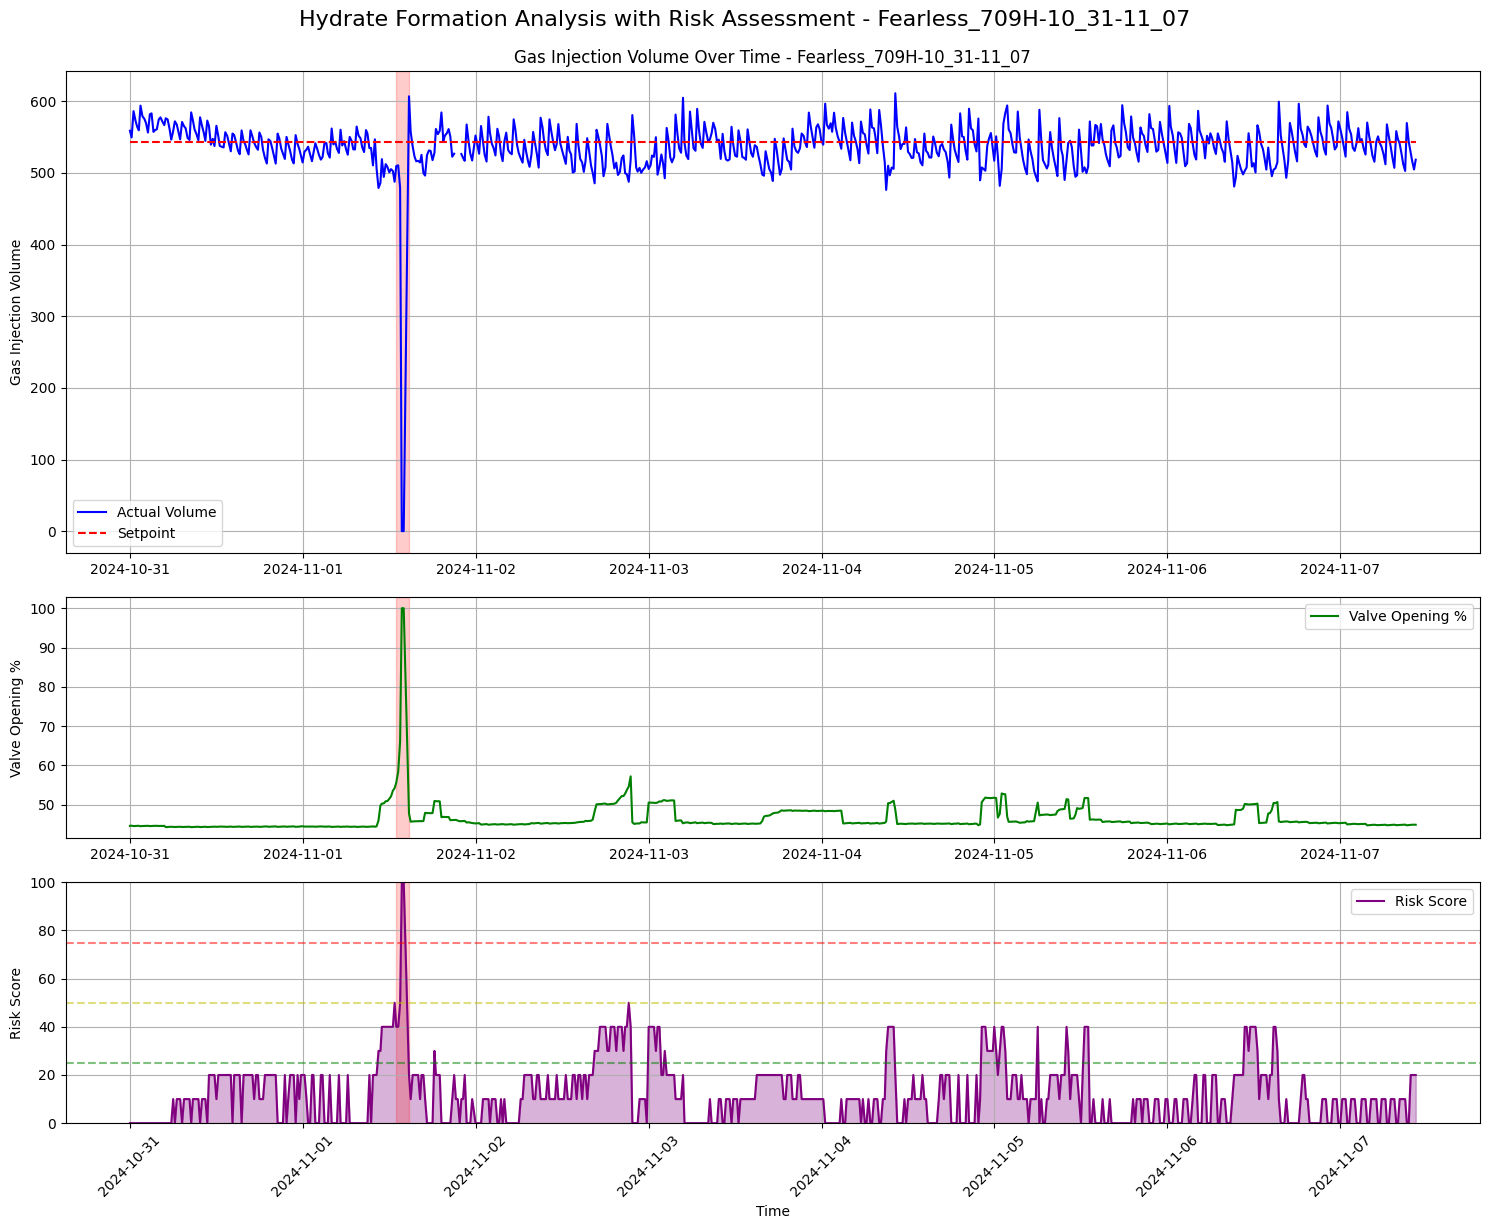


Risk Analysis for Fearless_709H-10_31-11_07:
--------------------------------------------------
Average Risk Score: 11.98
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.3%
Time spent in medium risk (50-75): 0.0%
Time spent in low risk (<50): 99.7%

Processing ./data/Gallant_102H-10_04-10_11.csv...


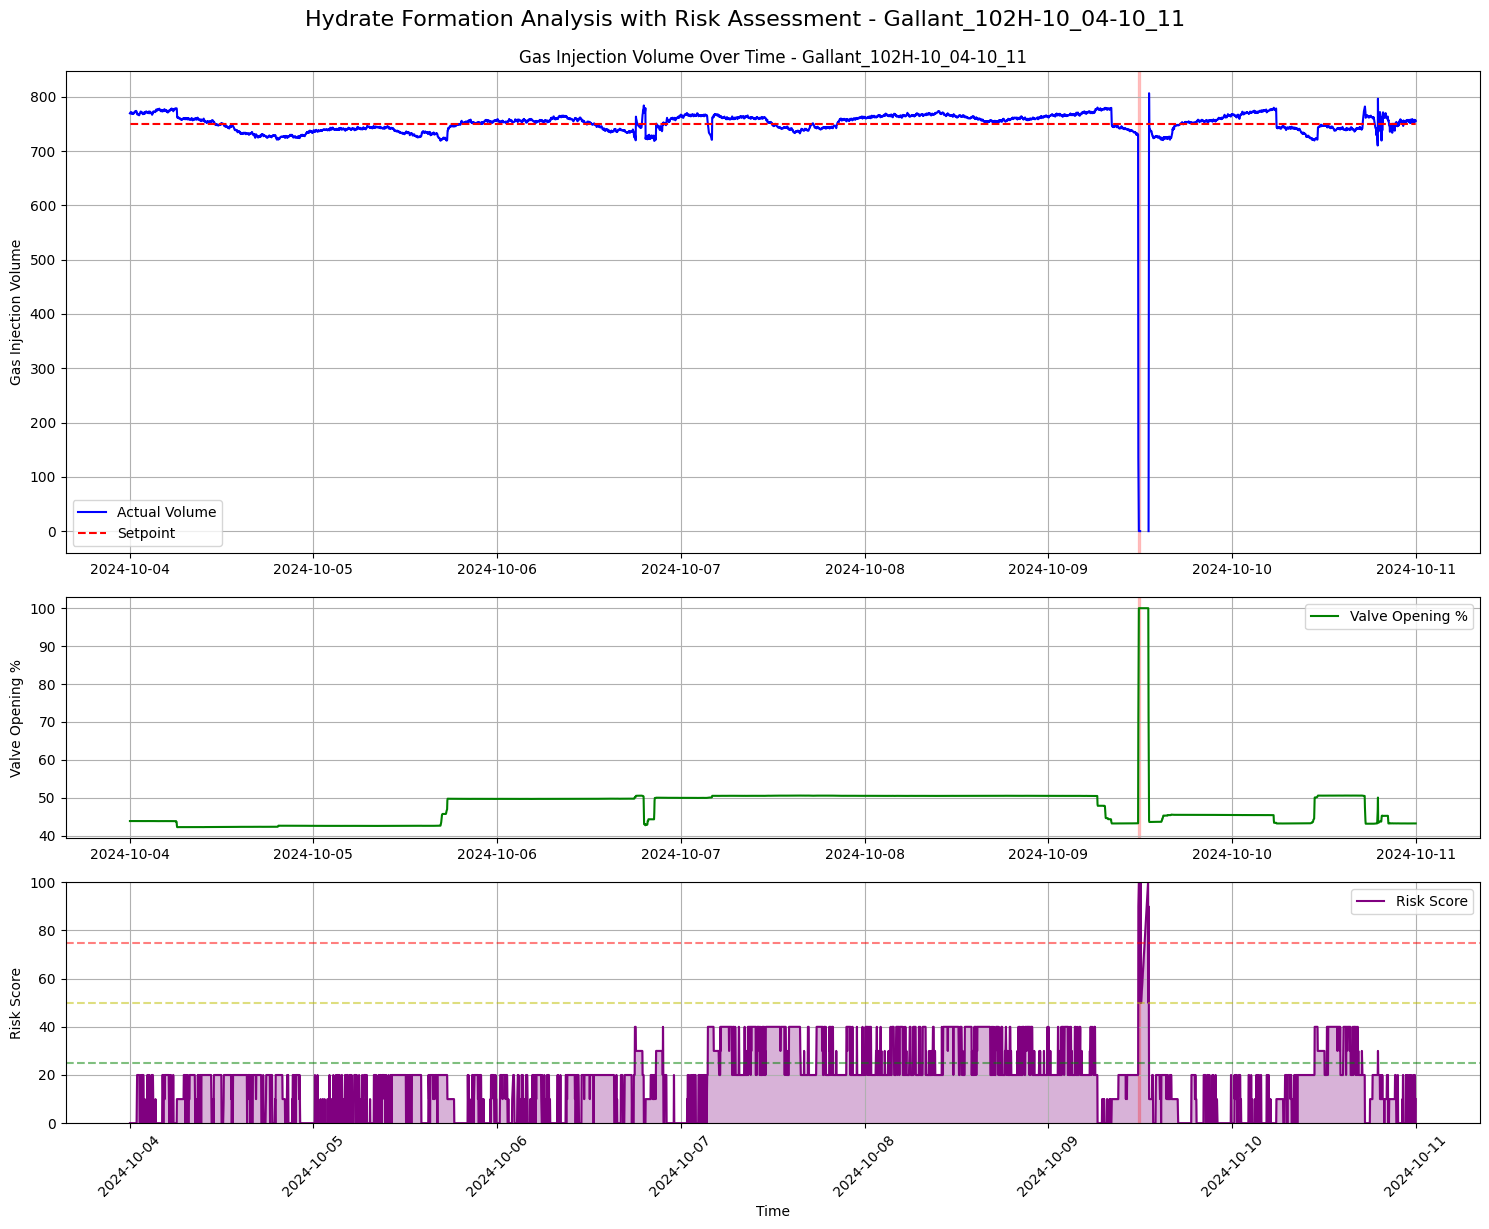


Risk Analysis for Gallant_102H-10_04-10_11:
--------------------------------------------------
Average Risk Score: 17.10
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.1%
Time spent in medium risk (50-75): 0.0%
Time spent in low risk (<50): 99.9%

Processing ./data/Noble_4H-10_24-10_29.csv...


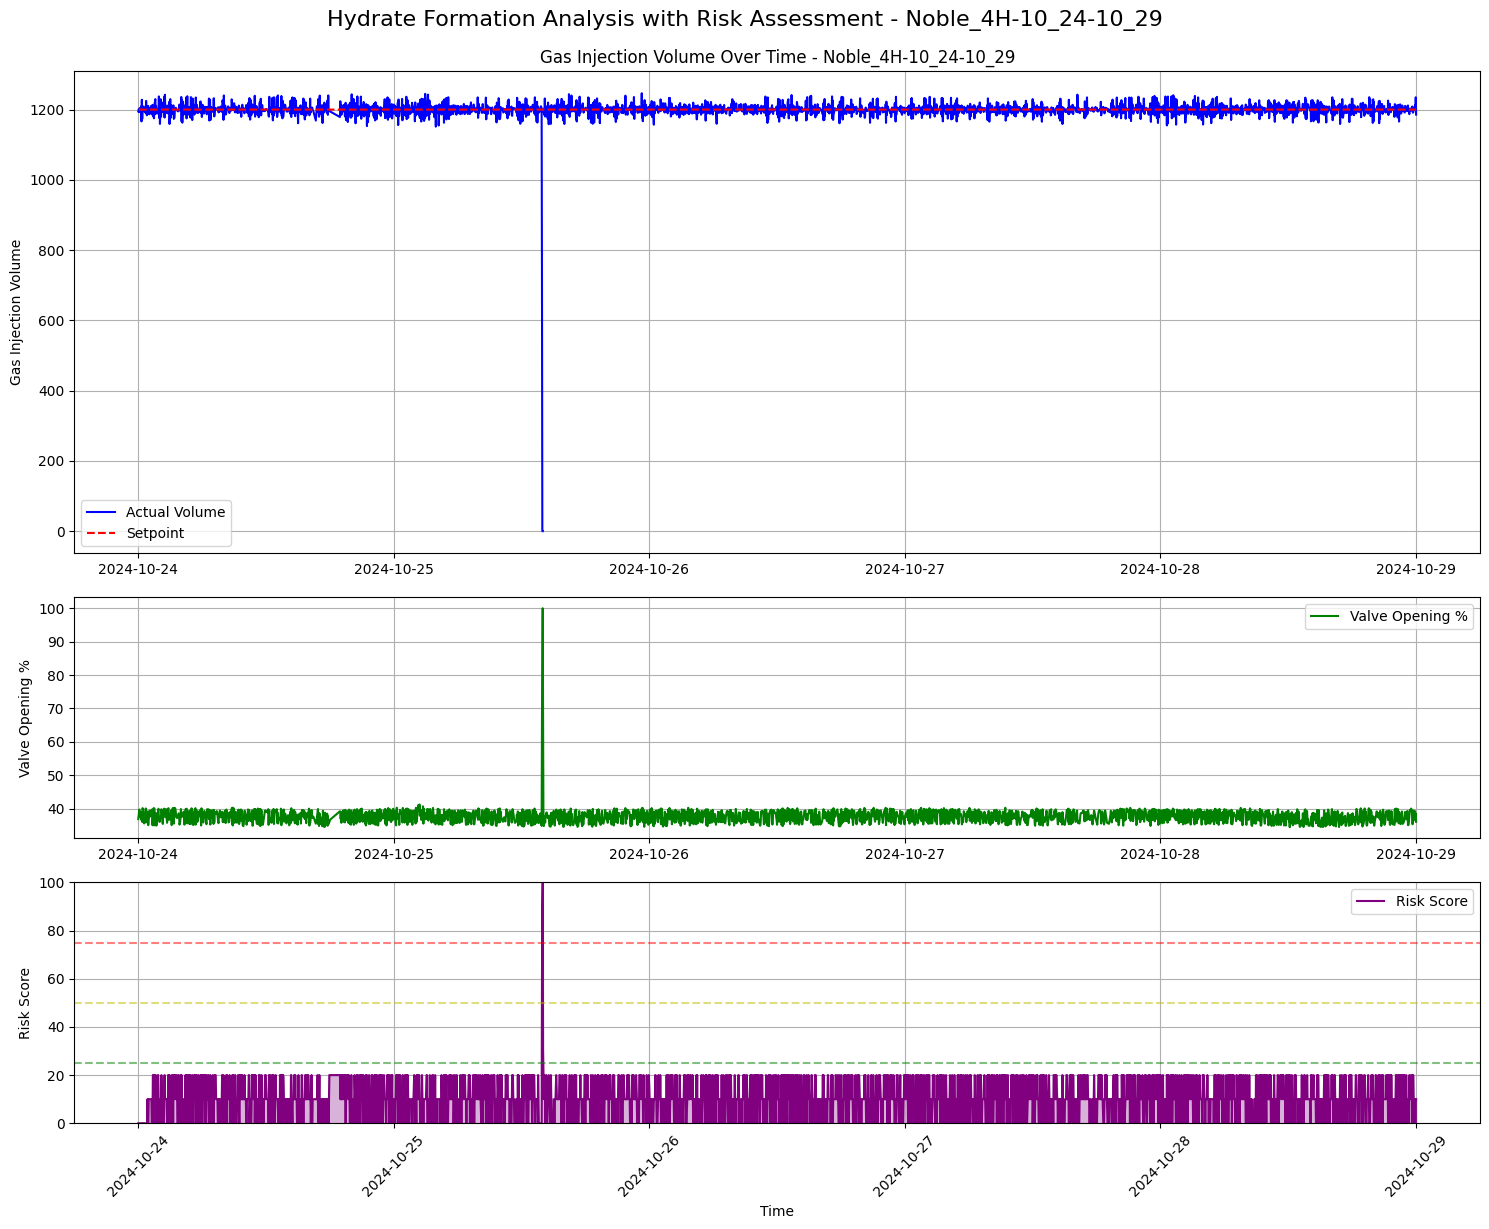


Risk Analysis for Noble_4H-10_24-10_29:
--------------------------------------------------
Average Risk Score: 9.90
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.1%
Time spent in medium risk (50-75): 0.0%
Time spent in low risk (<50): 99.9%

Processing ./data/Resolute_728H-10_14-10_21.csv...


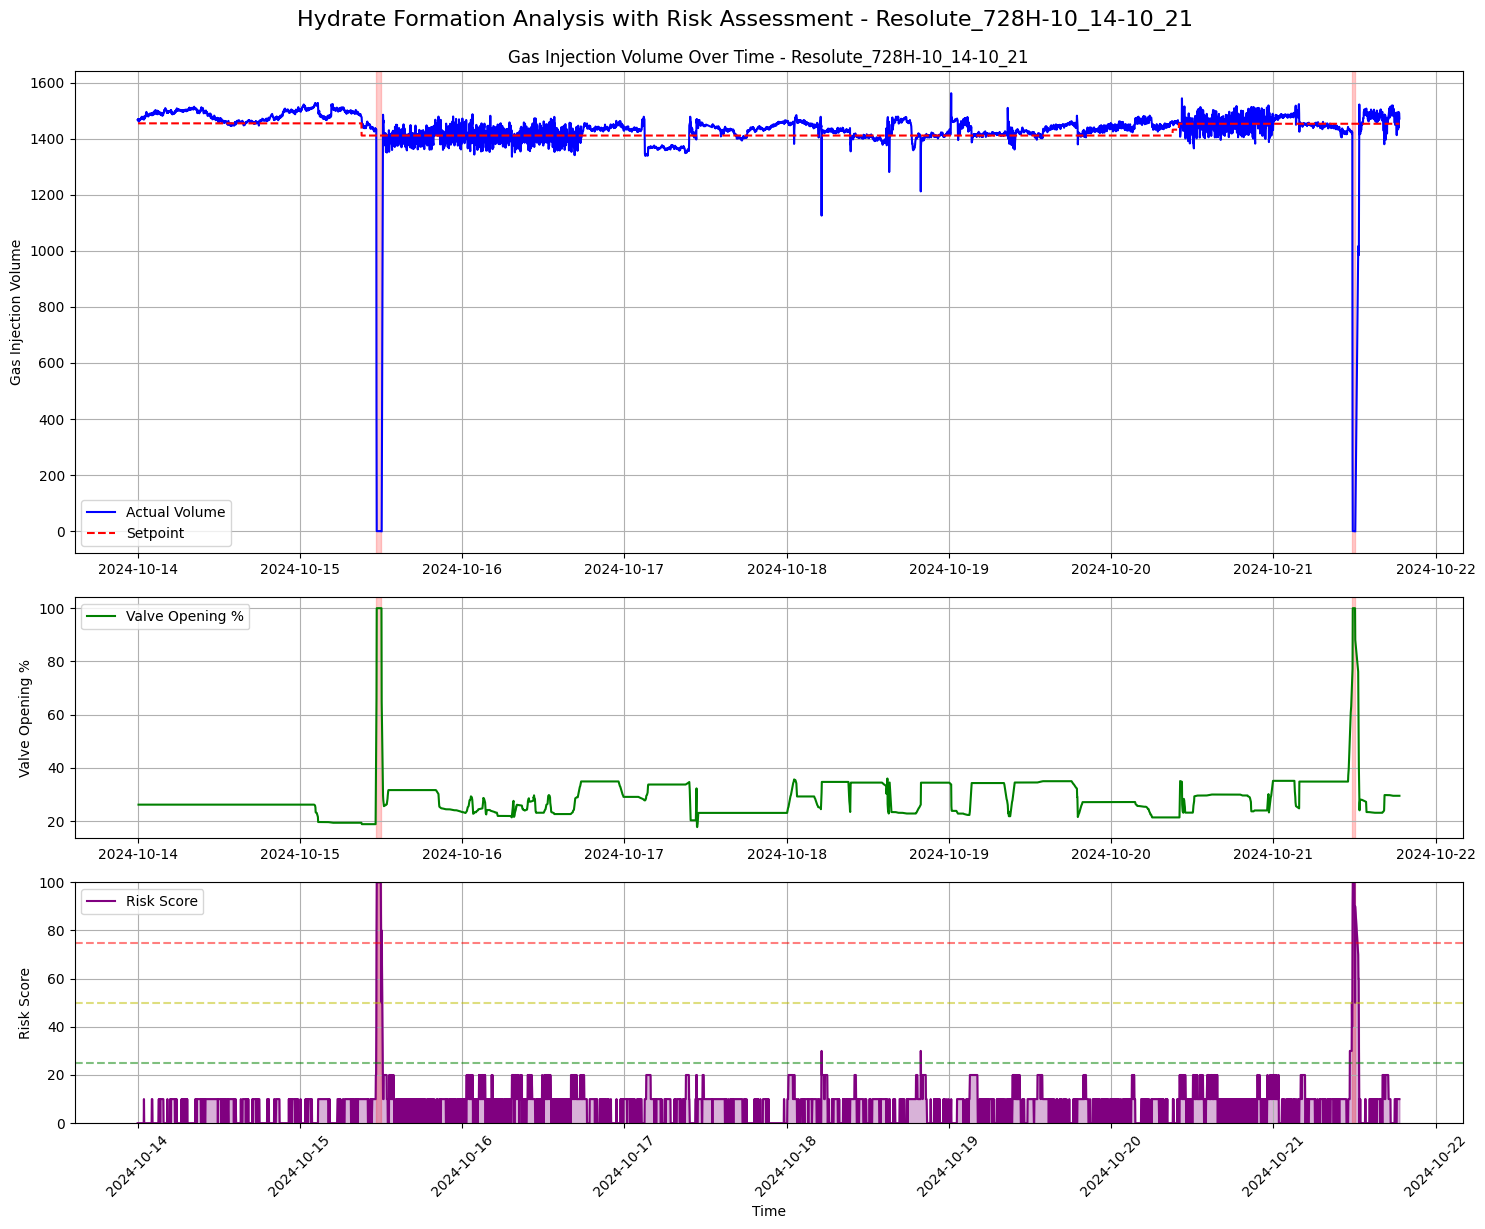


Risk Analysis for Resolute_728H-10_14-10_21:
--------------------------------------------------
Average Risk Score: 6.86
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.2%
Time spent in medium risk (50-75): 0.1%
Time spent in low risk (<50): 99.8%

Processing ./data/Ruthless_745H-10_01-10_08.csv...


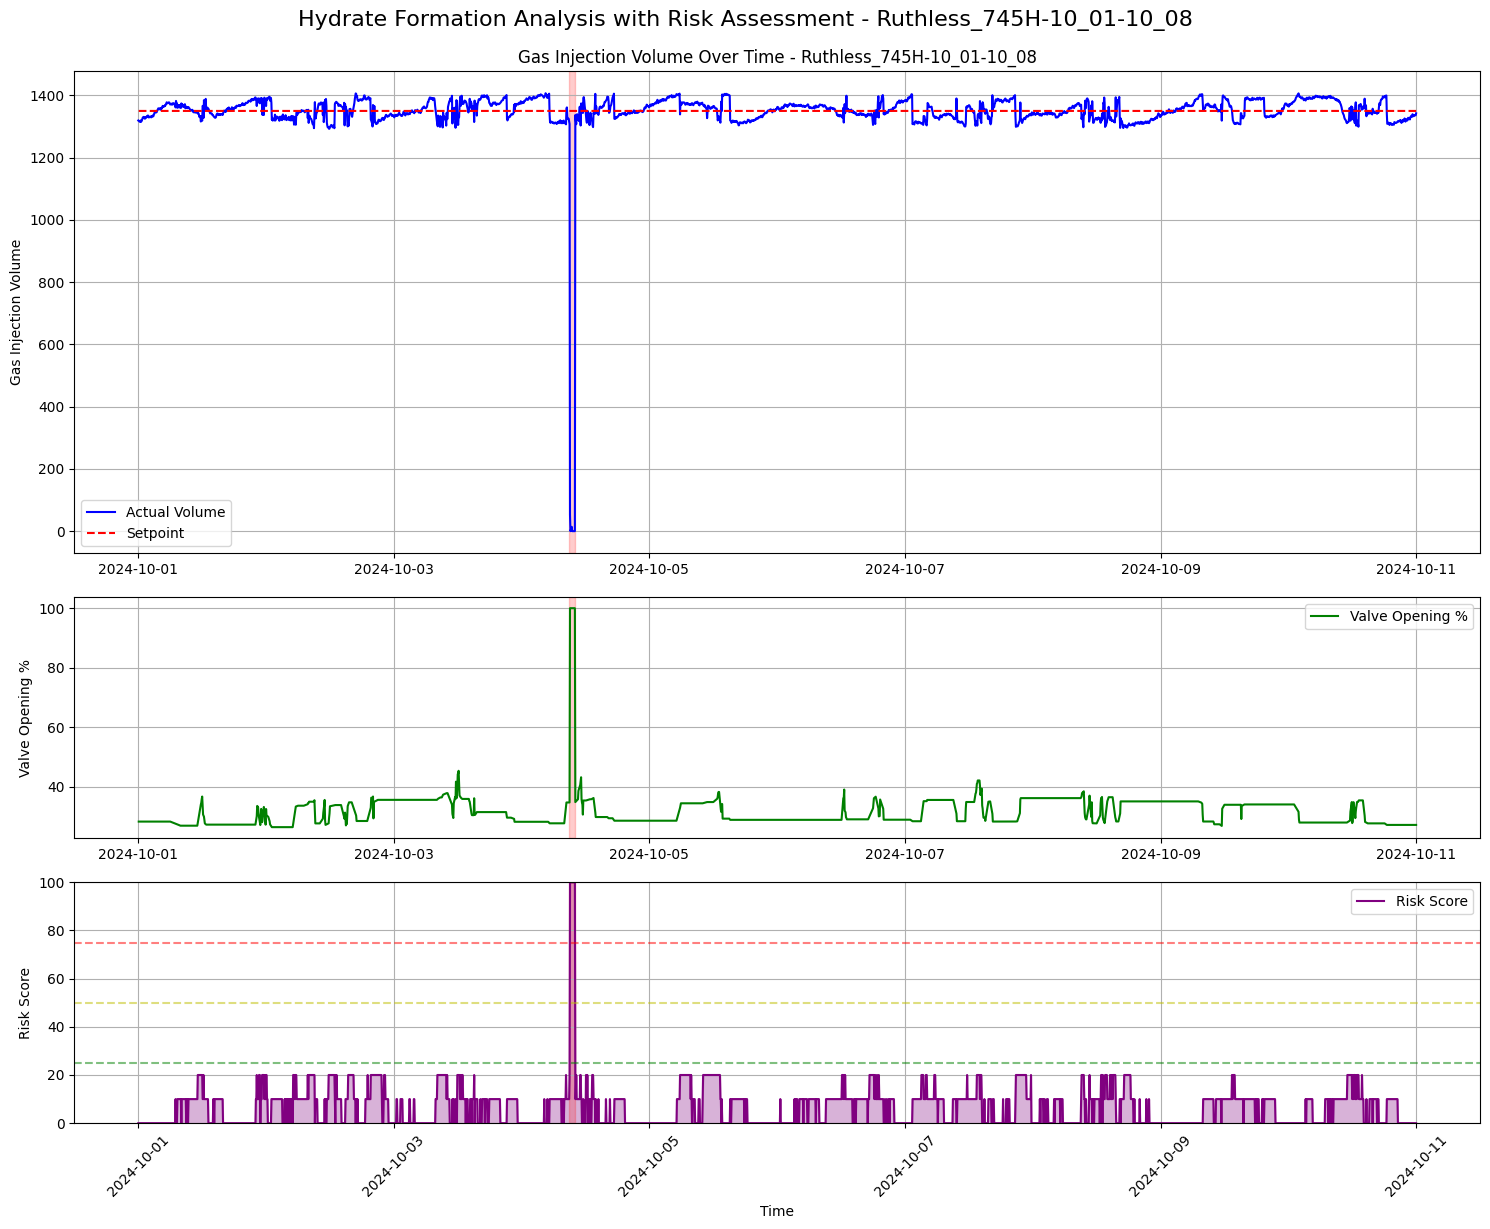


Risk Analysis for Ruthless_745H-10_01-10_08:
--------------------------------------------------
Average Risk Score: 6.49
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.2%
Time spent in medium risk (50-75): 0.0%
Time spent in low risk (<50): 99.8%

Processing ./data/Steadfast_505H-10_30-11_07.csv...
Error processing ./data/Steadfast_505H-10_30-11_07.csv: time data "10/30/2024 12:00:00 pm" doesn't match format "%m/%d/%Y %H:%M:%S am", at position 93. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

Processing ./data/Valiant_505H-09_22-09_30.csv...


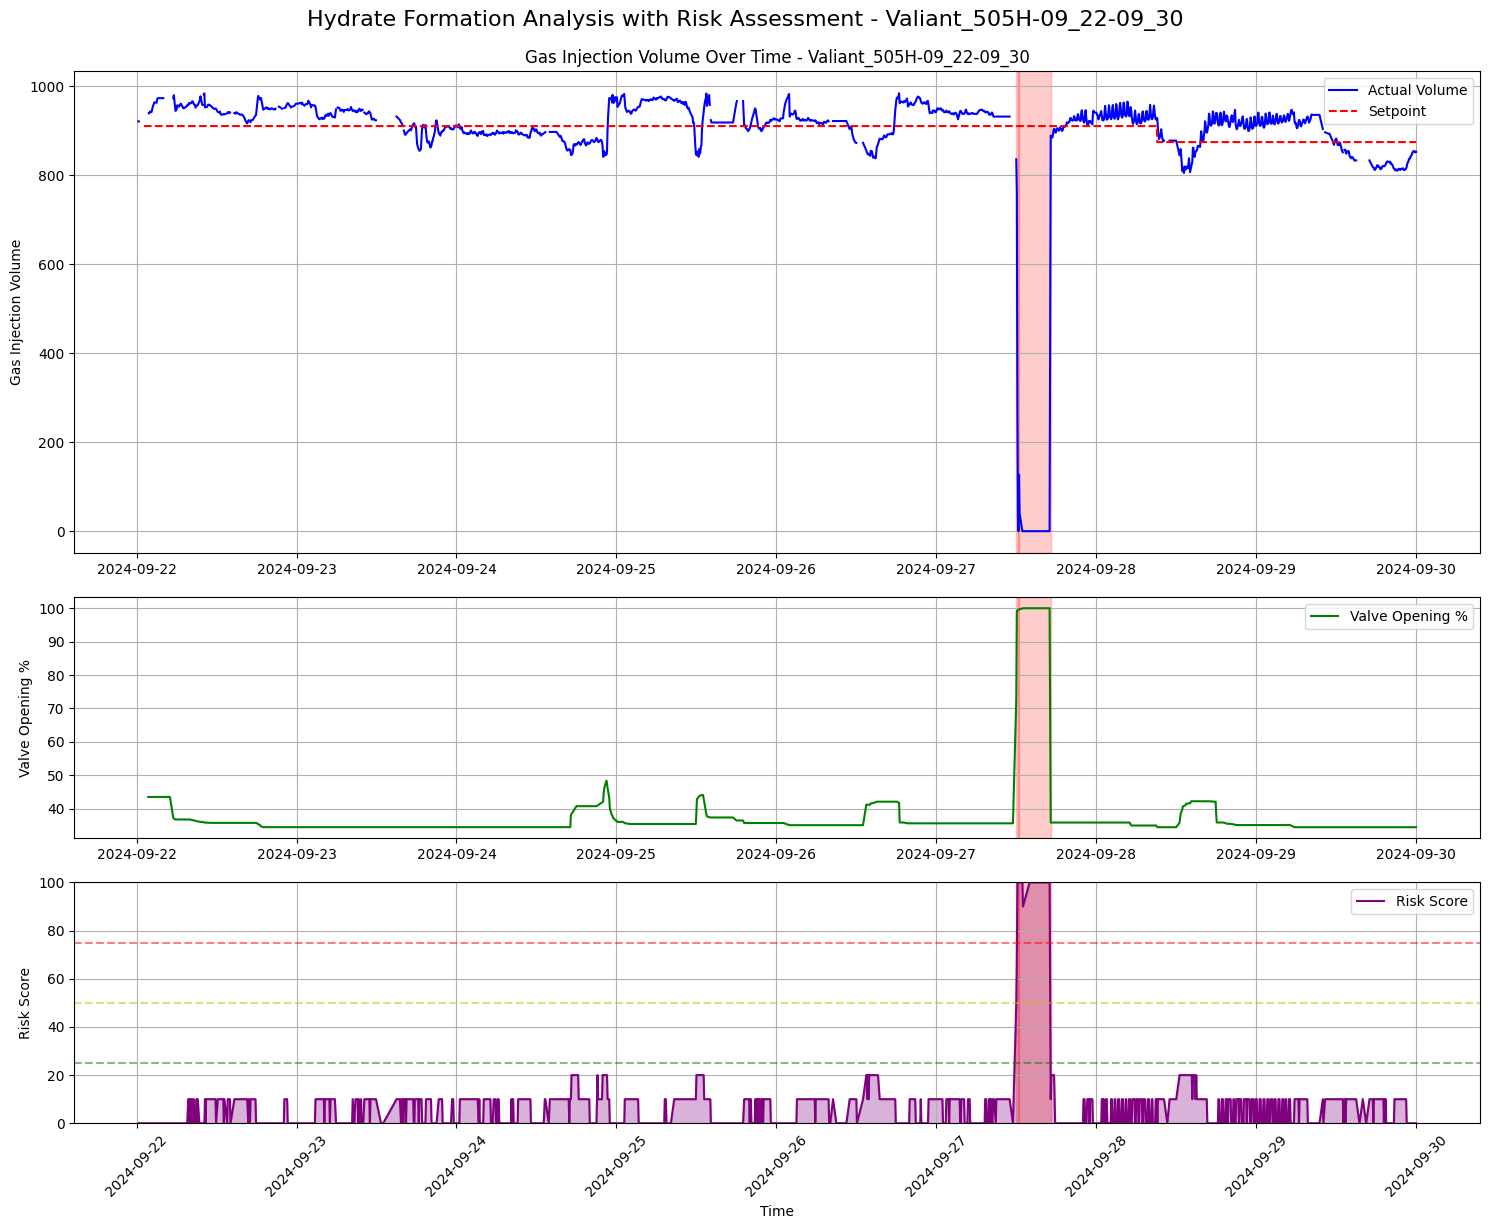


Risk Analysis for Valiant_505H-09_22-09_30:
--------------------------------------------------
Average Risk Score: 6.79
Maximum Risk Score: 100.00
Time spent in high risk (>75): 0.8%
Time spent in medium risk (50-75): 0.1%
Time spent in low risk (<50): 99.1%


In [13]:
# First, let's create a function to extract features that might help predict hydrate formation
def extract_features(df, lookback_window=6):  # lookback_window in hours
    """
    Extract features that might indicate upcoming hydrate formation
    """
    # Calculate number of samples in lookback window (assuming 15-min intervals)
    window_samples = int(lookback_window * 4)

    df_features = df.copy()

    # Calculate rolling statistics
    df_features['volume_std'] = df_features['Inj Gas Meter Volume Instantaneous'].rolling(window=window_samples).std()
    df_features['volume_trend'] = df_features['Inj Gas Meter Volume Instantaneous'].diff(periods=window_samples)
    df_features['valve_trend'] = df_features['Inj Gas Valve Percent Open'].diff(periods=window_samples)
    df_features['volume_deviation_mean'] = df_features['Volume_Deviation'].rolling(window=window_samples).mean()

    # Create binary labels for hydrate events (1 for event, 0 for no event)
    df_features['hydrate_event'] = 0

    return df_features

def calculate_risk_score(current_data, historical_data=None):
    """
    Calculate risk score for hydrate formation based on current conditions
    Returns score between 0-100
    """
    risk_score = 0

    # Base risk factors
    volume = current_data['Inj Gas Meter Volume Instantaneous']
    setpoint = current_data['Inj Gas Meter Volume Setpoint']
    valve = current_data['Inj Gas Valve Percent Open']

    # Volume-based risk (40% of total score)
    volume_deviation_percent = abs((setpoint - volume) / setpoint * 100)
    if volume_deviation_percent > 50:
        risk_score += 40
    elif volume_deviation_percent > 25:
        risk_score += 20
    elif volume_deviation_percent > 10:
        risk_score += 10

    # Valve-based risk (40% of total score)
    if valve > 90:
        risk_score += 40
    elif valve > 70:
        risk_score += 30
    elif valve > 50:
        risk_score += 20

    # Trend-based risk (20% of total score)
    if 'volume_trend' in current_data and current_data['volume_trend'] < 0:
        risk_score += 10
    if 'valve_trend' in current_data and current_data['valve_trend'] > 0:
        risk_score += 10

    return risk_score

# Let's create a visualization function that includes risk assessment
def plot_well_data_with_risk(df_processed, events, well_name):
    """Create detailed visualization including risk assessment"""
    # Calculate features and risk scores
    df_features = extract_features(df_processed)
    df_features['risk_score'] = df_features.apply(calculate_risk_score, axis=1)

    # Create figure with three subplots
    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

    # Gas Injection Volume subplot
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df_features['Time'], df_features['Inj Gas Meter Volume Instantaneous'],
             label='Actual Volume', color='blue')
    ax1.plot(df_features['Time'], df_features['Inj Gas Meter Volume Setpoint'],
             label='Setpoint', color='red', linestyle='--')

    # Highlight events
    for event in events:
        ax1.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

    ax1.set_ylabel('Gas Injection Volume')
    ax1.set_title(f'Gas Injection Volume Over Time - {well_name}')
    ax1.legend()
    ax1.grid(True)

    # Valve Opening subplot
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(df_features['Time'], df_features['Inj Gas Valve Percent Open'],
             label='Valve Opening %', color='green')

    # Highlight events
    for event in events:
        ax2.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

    ax2.set_ylabel('Valve Opening %')
    ax2.legend()
    ax2.grid(True)

    # Risk Score subplot
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(df_features['Time'], df_features['risk_score'],
             label='Risk Score', color='purple')
    ax3.fill_between(df_features['Time'], df_features['risk_score'], alpha=0.3, color='purple')

    # Highlight events
    for event in events:
        ax3.axvspan(event['start_time'], event['end_time'], color='red', alpha=0.2)

    # Add risk level bands
    ax3.axhline(y=75, color='r', linestyle='--', alpha=0.5)
    ax3.axhline(y=50, color='y', linestyle='--', alpha=0.5)
    ax3.axhline(y=25, color='g', linestyle='--', alpha=0.5)

    ax3.set_ylabel('Risk Score')
    ax3.set_xlabel('Time')
    ax3.set_ylim(0, 100)
    ax3.legend()
    ax3.grid(True)

    plt.xticks(rotation=45)
    plt.tight_layout()

    # Add a title for the entire figure
    fig.suptitle(f'Hydrate Formation Analysis with Risk Assessment - {well_name}',
                y=1.02, fontsize=16)

    plt.show()

    # Print risk analysis
    print(f"\nRisk Analysis for {well_name}:")
    print("-" * 50)
    print(f"Average Risk Score: {df_features['risk_score'].mean():.2f}")
    print(f"Maximum Risk Score: {df_features['risk_score'].max():.2f}")
    print(f"Time spent in high risk (>75): {(df_features['risk_score'] > 75).mean()*100:.1f}%")
    print(f"Time spent in medium risk (50-75): {((df_features['risk_score'] > 50) & (df_features['risk_score'] <= 75)).mean()*100:.1f}%")
    print(f"Time spent in low risk (<50): {(df_features['risk_score'] <= 50).mean()*100:.1f}%")

# Process and analyze each file
for file_path in csv_files:
    if os.path.exists(file_path):
        try:
            print(f"\nProcessing {file_path}...")

            # Read and process the data
            df = pd.read_csv(file_path)
            df_processed = preprocess_data(df)

            # Detect hydrate events
            events = detect_hydrate_formation(df_processed)

            # Get well name from file name
            well_name = os.path.basename(file_path).split('.')[0]

            # Create visualization with risk assessment
            plot_well_data_with_risk(df_processed, events, well_name)

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
    else:
        print(f"File not found: {file_path}")

In [15]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.9 MB/s eta 0:00:00


In [16]:
# Save this as app.py
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Reuse our previous functions (preprocess_data, detect_hydrate_formation, etc.)
# [Previous functions remain the same]

def create_plotly_visualization(df_processed, events, well_name):
    """Create an interactive Plotly visualization"""
    # Create figure with secondary y-axis
    fig = make_subplots(rows=3, cols=1,
                       shared_xaxes=True,
                       vertical_spacing=0.05,
                       subplot_titles=('Gas Injection Volume',
                                     'Valve Opening Percentage',
                                     'Risk Score'))

    # Add traces for gas injection
    fig.add_trace(
        go.Scatter(x=df_processed['Time'],
                  y=df_processed['Inj Gas Meter Volume Instantaneous'],
                  name="Actual Volume",
                  line=dict(color='blue')),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=df_processed['Time'],
                  y=df_processed['Inj Gas Meter Volume Setpoint'],
                  name="Setpoint",
                  line=dict(color='red', dash='dash')),
        row=1, col=1
    )

    # Add trace for valve opening
    fig.add_trace(
        go.Scatter(x=df_processed['Time'],
                  y=df_processed['Inj Gas Valve Percent Open'],
                  name="Valve Opening %",
                  line=dict(color='green')),
        row=2, col=1
    )

    # Add risk score
    df_features = extract_features(df_processed)
    df_features['risk_score'] = df_features.apply(calculate_risk_score, axis=1)
    fig.add_trace(
        go.Scatter(x=df_features['Time'],
                  y=df_features['risk_score'],
                  name="Risk Score",
                  fill='tozeroy',
                  line=dict(color='purple')),
        row=3, col=1
    )

    # Add event highlighting
    for event in events:
        for row in [1, 2, 3]:
            fig.add_vrect(
                x0=event['start_time'],
                x1=event['end_time'],
                fillcolor="red",
                opacity=0.2,
                layer="below",
                line_width=0,
                row=row, col=1
            )

    # Update layout
    fig.update_layout(
        height=800,
        title_text=f"Hydrate Formation Analysis - {well_name}",
        showlegend=True,
        hovermode='x unified'
    )

    return fig

def main():
    st.set_page_config(page_title="Hydrate Formation Analysis", layout="wide")

    st.title("Hydrate Formation Analysis Dashboard")

    # Sidebar
    st.sidebar.title("Controls")

    # File selection
    csv_files = [f for f in os.listdir() if f.endswith('.csv')]
    selected_file = st.sidebar.selectbox("Select Well Data", csv_files)

    # Risk threshold controls
    st.sidebar.subheader("Risk Thresholds")
    volume_risk_threshold = st.sidebar.slider("Volume Deviation Risk Threshold (%)", 0, 100, 50)
    valve_risk_threshold = st.sidebar.slider("Valve Opening Risk Threshold (%)", 0, 100, 90)

    # Load and process data
    if selected_file:
        df = pd.read_csv(selected_file)
        df_processed = preprocess_data(df)
        events = detect_hydrate_formation(df_processed,
                                        min_volume_threshold=volume_risk_threshold,
                                        max_valve_threshold=valve_risk_threshold)

        # Main content
        col1, col2 = st.columns([2, 1])

        with col1:
            st.plotly_chart(create_plotly_visualization(df_processed, events,
                                                      selected_file.split('.')[0]),
                           use_container_width=True)

        with col2:
            st.subheader("Event Summary")
            if events:
                for i, event in enumerate(events, 1):
                    st.write(f"Event {i}:")
                    st.write(f"Start: {event['start_time']}")
                    st.write(f"End: {event['end_time']}")
                    st.write(f"Duration: {event['duration']}")
                    st.write(f"Volume Drop: {event['initial_volume'] - event['final_volume']:.2f}")
                    st.write("---")
            else:
                st.write("No hydrate events detected")

            # Statistics
            st.subheader("Well Statistics")
            df_features = extract_features(df_processed)
            df_features['risk_score'] = df_features.apply(calculate_risk_score, axis=1)

            stats_col1, stats_col2 = st.columns(2)
            with stats_col1:
                st.metric("Average Volume",
                         f"{df_processed['Inj Gas Meter Volume Instantaneous'].mean():.2f}")
                st.metric("Average Risk Score",
                         f"{df_features['risk_score'].mean():.2f}")

            with stats_col2:
                st.metric("Average Valve Opening",
                         f"{df_processed['Inj Gas Valve Percent Open'].mean():.2f}%")
                st.metric("Max Risk Score",
                         f"{df_features['risk_score'].max():.2f}")

            # Risk distribution
            st.subheader("Risk Distribution")
            high_risk = (df_features['risk_score'] > 75).mean() * 100
            medium_risk = ((df_features['risk_score'] > 50) &
                         (df_features['risk_score'] <= 75)).mean() * 100
            low_risk = (df_features['risk_score'] <= 50).mean() * 100

            st.bar_chart({
                'High Risk (>75)': [high_risk],
                'Medium Risk (50-75)': [medium_risk],
                'Low Risk (<50)': [low_risk]
            })

if __name__ == "__main__":
    main()

2024-11-17 05:42:08.399 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 05:42:08.409 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 05:42:08.899 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-11-17 05:42:08.912 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 05:42:08.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 05:42:08.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-17 05:42:08.923 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runn